# import

In [1]:
import numpy as np
import tensorflow as tf
import os
import keras
from keras import backend as K
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.engine.training import Model
from keras.layers import Activation
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
import matplotlib.pyplot as plt

/home/ryantsan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import cv2
from keras.utils import np_utils
from keras.datasets import fashion_mnist
%matplotlib inline

In [3]:
os.sys.path

['',
 '/home/ryantsan/anaconda3/lib/python36.zip',
 '/home/ryantsan/anaconda3/lib/python3.6',
 '/home/ryantsan/anaconda3/lib/python3.6/lib-dynload',
 '/home/ryantsan/.local/lib/python3.6/site-packages',
 '/home/ryantsan/anaconda3/lib/python3.6/site-packages',
 '/home/ryantsan/anaconda3/lib/python3.6/site-packages/IPython/extensions',
 '/home/ryantsan/.ipython']

# GPU related

In [4]:
# multi GPU Training Test (add by ryan: the important one is the multi_gpu_model import from Keras)
from keras.callbacks import LearningRateScheduler
from keras.utils.training_utils import multi_gpu_model
from keras.optimizers import SGD

In [5]:
# reset
K.clear_session()

# This one is to test whether Keras can see the GPUs
K.get_session().list_devices() 

# Add by Ryan: configure tensorflow backend to increase the GPU memory allocation gradually and stopping the memory allocation failure during traiing
config = tf.ConfigProto( device_count = {'GPU':2, 'CPU':4})
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)

# assist function

In [6]:
def get_labels(arr):
  labels = np.zeros( (arr.shape[0],1) )
  for i in range(0,arr.shape[0]):
    row = arr[i,]
    labels[i,0]=np.where(row==np.max(row,axis=0))[0]
  return labels

In [7]:
def plot_model(model_details):

    # Create sub-plots
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_details.history['loss'])+1),model_details.history['loss'])
    axs[1].plot(range(1,len(model_details.history['val_loss'])+1),model_details.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_details.history['loss'])+1),len(model_details.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_details.history['acc'])+1),model_details.history['acc'])
    axs[0].plot(range(1,len(model_details.history['val_acc'])+1),model_details.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_details.history['acc'])+1),len(model_details.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Show the plot
    plt.show()

In [8]:
def img_resize(org_imgs, target_size):
  x_imgs = []
  for i in range(0,org_imgs.shape[0]):
    x_img = cv2.resize(org_imgs[i], dsize=(target_size, target_size), interpolation=cv2.INTER_CUBIC)
    x_imgs.append(x_img)
  return np.array(x_imgs)

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# data generate

## general

In [10]:
(images, labels), (_, _) = fashion_mnist.load_data()

In [11]:
class_labels = ['0','1','2','3','4','5','6','7','8','9']
NUM_OF_CLASS = len(class_labels)

In [12]:
images_zoomed_in = img_resize(images, 48)
images_zoomed_in = images_zoomed_in.reshape(images_zoomed_in.shape[0], images_zoomed_in.shape[1], images_zoomed_in.shape[2], 1).astype('float32')

In [13]:
x_train = images_zoomed_in[0:50000]
x_test = images_zoomed_in[50000:60000]

y_train = labels[0:50000]
y_test = labels[50000:60000]

In [14]:
TRAIN_DATA_SIZE = x_train.shape[0]
TEST_DATA_SIZE = x_test.shape[0]

TRAIN_BATCH_SIZE = 20
TEST_BATCH_SIZE = 10

train_step = int(TRAIN_DATA_SIZE/TRAIN_BATCH_SIZE)
test_step = int(TEST_DATA_SIZE/TEST_BATCH_SIZE)

EPOCHS_NUM = 3

BASIC_TARGET_SIZE = 48

In [15]:
y_train_oh = np_utils.to_categorical(y_train, NUM_OF_CLASS)
y_test_oh = np_utils.to_categorical(y_test, NUM_OF_CLASS)

x_train_3d = np.concatenate((x_train, x_train), axis=3)
x_train_3d = np.concatenate((x_train_3d, x_train), axis=3)
x_test_3d = np.concatenate((x_test, x_test), axis=3)
x_test_3d = np.concatenate((x_test_3d, x_test), axis=3)

## self data batches

In [17]:
train_self_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
train_self_gen.fit(x_train_3d)
train_self_batches = train_self_gen.flow(x_train_3d, y_train_oh, batch_size=TRAIN_BATCH_SIZE, shuffle=False, seed=10)

test_self_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_self_gen.fit(x_train_3d)
test_self_batches = test_self_gen.flow(x_test_3d, y_test_oh, batch_size=TEST_BATCH_SIZE, shuffle=False, seed=10)

## vgg16 data batches

In [18]:
x_train_vgg_3d = keras.applications.vgg16.preprocess_input(x_train_3d)
x_test_vgg_3d = keras.applications.vgg16.preprocess_input(x_test_3d)

train_vgg_batches = ImageDataGenerator().flow(x_train_vgg_3d, y_train_oh, batch_size=TRAIN_BATCH_SIZE, shuffle=False, seed=10)
test_vgg_batches = ImageDataGenerator().flow(x_test_vgg_3d, y_test_oh, batch_size=TEST_BATCH_SIZE, shuffle=False, seed=10)

# create/tune model

In [19]:
def self_model(size, num_of_class):
    model = Sequential()
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=(size,size,3)))    
    model.add(Dropout(0.2))
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(Dropout(0.5))
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))    
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(Dropout(0.5))    
    model.add(Conv2D(192, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (1, 1),padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(num_of_class, (1, 1), padding='valid'))
    model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax'))
    return model

In [20]:
def keras_model(name, num=0,size=224, channel=1):
    if name=='vgg16':
        base_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(size,size,channel) )
    elif name=='inception_v3':
        base_model = keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(size,size,channel))
    else:
        return
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(NUM_OF_CLASS, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
    for i, layer in enumerate(base_model.layers):
      if i < len(base_model.layers) - num:
        layer.trainable = False
      else:
        layer.trainable = True
    return model

In [21]:
def train_model(train_batches, test_batches, model_type, num_of_train_layer, optimizer, learning_rate, epoch):
  
  model_file_name = 'models/' + model_type + '.' + str(num_of_train_layer) + '-' + optimizer + '-' + str(learning_rate) + '-' + str(epoch) + '.{epoch:02d}-{val_acc:.2f}-{val_loss:.2f}.h5'
  checkpoint = ModelCheckpoint(model_file_name, monitor='val_loss', verbose=0, save_best_only= True, mode='auto')
  
  if model_type == 'self':
    model = self_model(48, NUM_OF_CLASS)
  elif model_type == 'vgg16':
    model = keras_model('vgg16', size=48, channel = 3, num=num_of_train_layer)
  
  if optimizer == 'SGD':
    model.compile(SGD(lr=learning_rate), loss='categorical_crossentropy',metrics=['accuracy'])
  else:
    model.compile(Adam(lr=learning_rate), loss='categorical_crossentropy',metrics=['accuracy'])
  
  h = model.fit_generator(train_batches, steps_per_epoch=train_step, validation_data=test_batches, callbacks=[checkpoint], validation_steps=test_step, epochs=epoch, verbose=0)
  
  return model, h

In [22]:
def tune_model(train_batches, test_batches, model_type = 'self', range_num_of_train_layer = 0, optimizer_list = ['Adam'], learning_rate_list = [0.0001], epoch_list = [2]):
  
  if model_type == 'self':
    range_num_of_train_layer = 0

  for num_of_train_layer in range(0, range_num_of_train_layer + 1):
    for optimizer in optimizer_list:
      for learning_rate in learning_rate_list:
        for epoch in epoch_list:
          print('current variables:' + model_type + '.' + str(num_of_train_layer) + '-' + optimizer + '-' + str(learning_rate) + '-' + str(epoch) )
          model, h = train_model(train_batches, test_batches, model_type, num_of_train_layer, optimizer, learning_rate, epoch)
          print('current variables:' + model_type + '.' + str(num_of_train_layer) + '-' + optimizer + '-' + str(learning_rate) + '-' + str(epoch) )
          plot_model(h)
  return

# train model

current variables:vgg16.0-Adam-0.001-25
current variables:vgg16.0-Adam-0.001-25


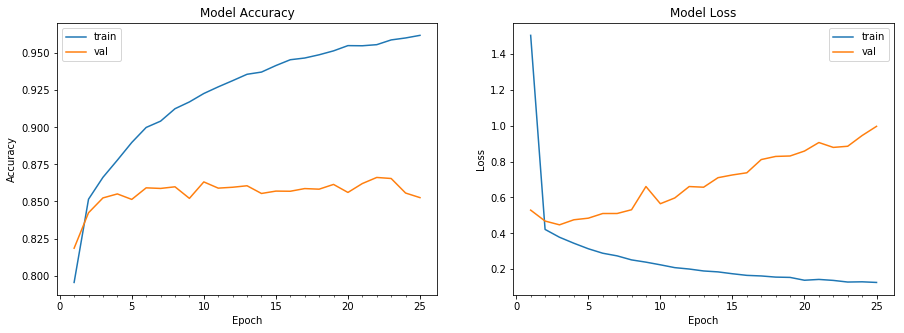

current variables:vgg16.0-Adam-0.001-50
current variables:vgg16.0-Adam-0.001-50


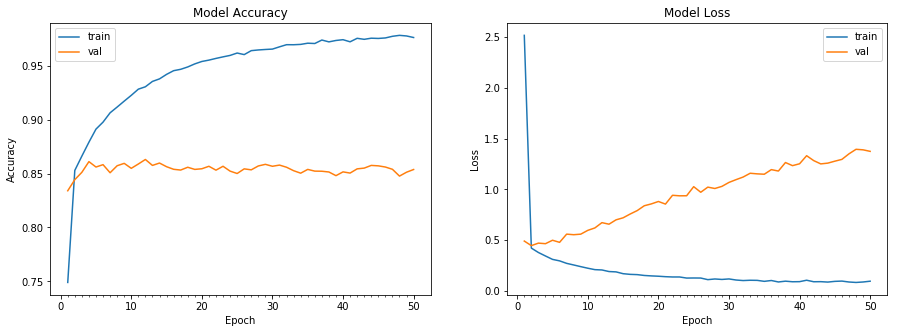

current variables:vgg16.0-Adam-0.001-75
current variables:vgg16.0-Adam-0.001-75


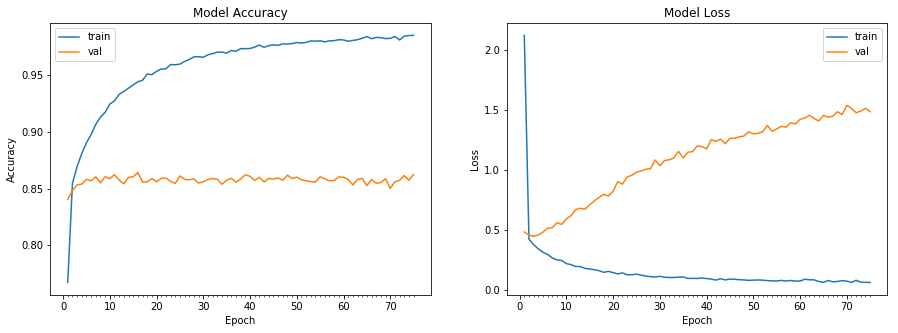

current variables:vgg16.0-Adam-0.01-25
current variables:vgg16.0-Adam-0.01-25


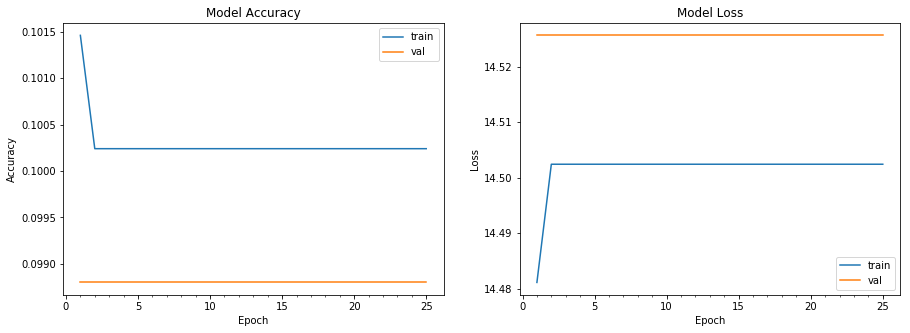

current variables:vgg16.0-Adam-0.01-50
current variables:vgg16.0-Adam-0.01-50


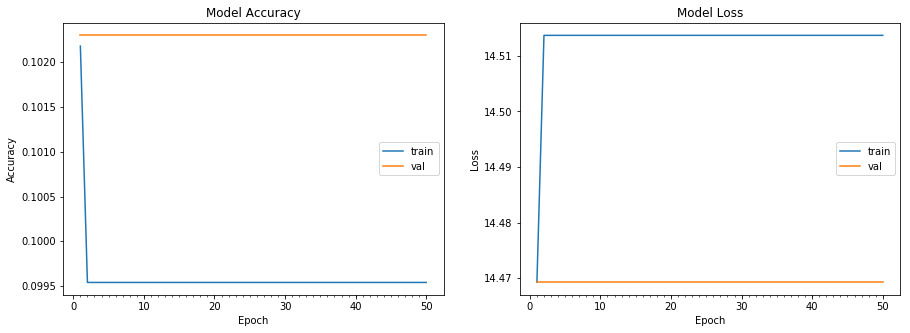

current variables:vgg16.0-Adam-0.01-75
current variables:vgg16.0-Adam-0.01-75


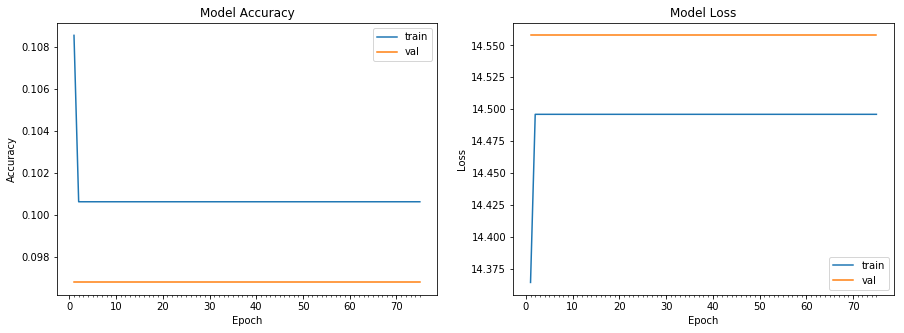

current variables:vgg16.0-Adam-0.1-25
current variables:vgg16.0-Adam-0.1-25


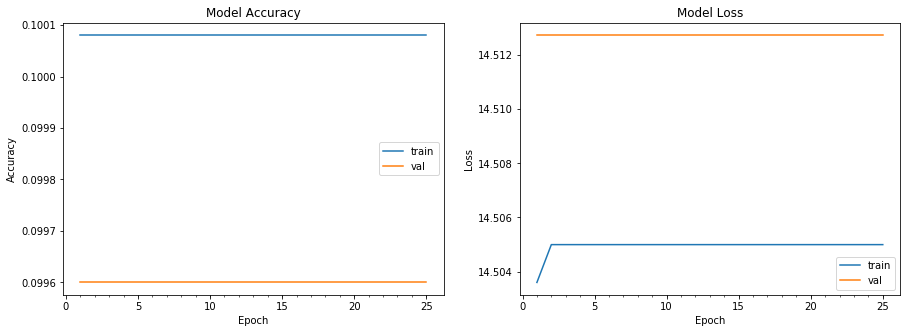

current variables:vgg16.0-Adam-0.1-50
current variables:vgg16.0-Adam-0.1-50


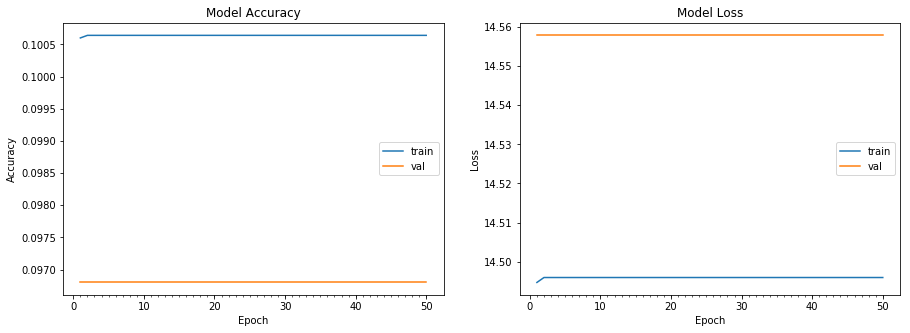

current variables:vgg16.0-Adam-0.1-75
current variables:vgg16.0-Adam-0.1-75


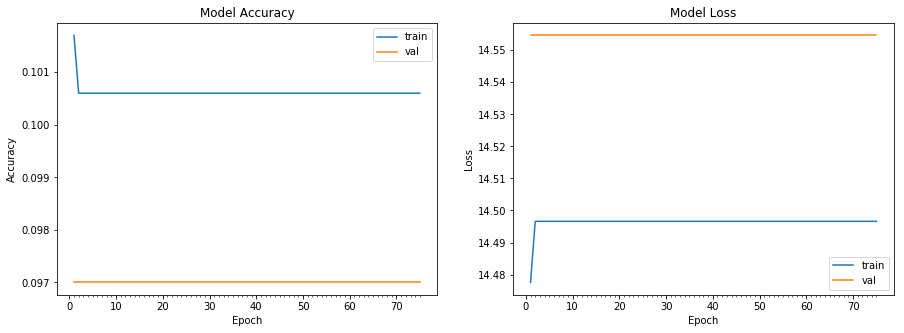

current variables:vgg16.0-Adam-0.3-25
current variables:vgg16.0-Adam-0.3-25


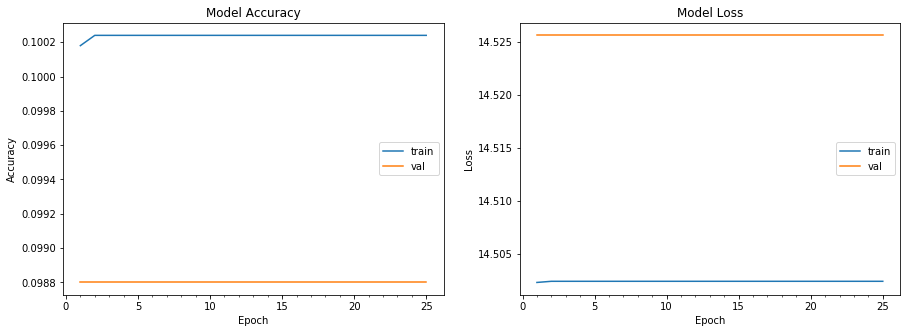

current variables:vgg16.0-Adam-0.3-50
current variables:vgg16.0-Adam-0.3-50


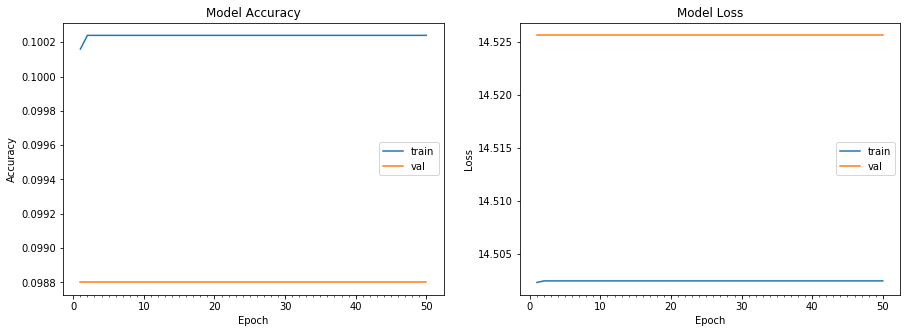

current variables:vgg16.0-Adam-0.3-75
current variables:vgg16.0-Adam-0.3-75


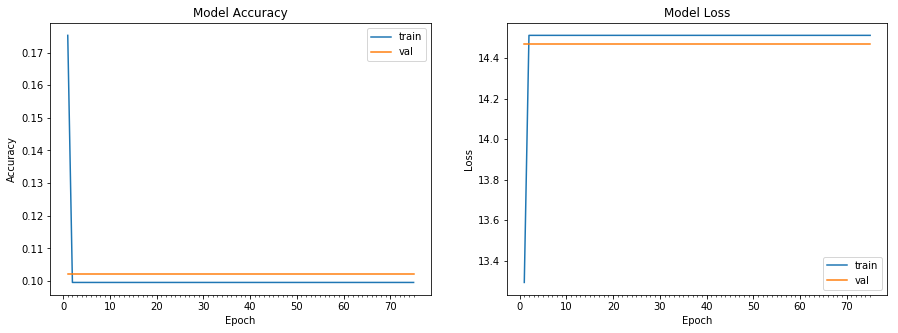

current variables:vgg16.0-SGD-0.001-25
current variables:vgg16.0-SGD-0.001-25


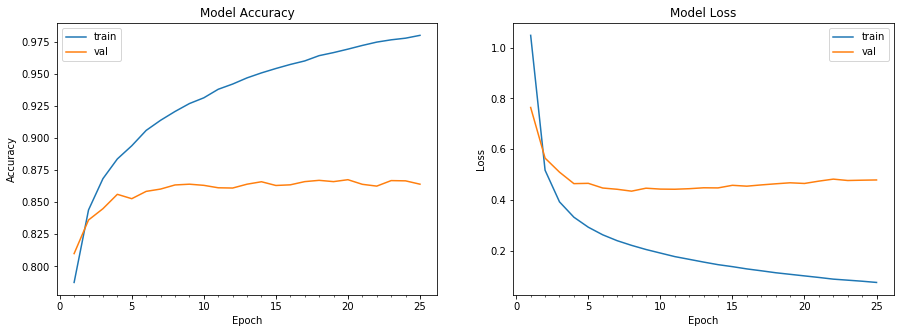

current variables:vgg16.0-SGD-0.001-50
current variables:vgg16.0-SGD-0.001-50


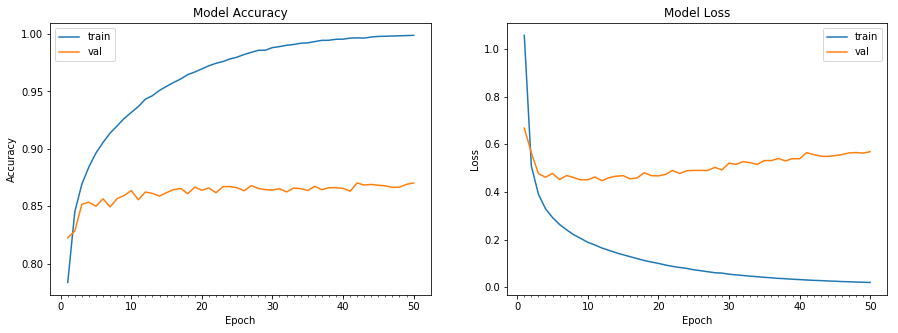

current variables:vgg16.0-SGD-0.001-75
current variables:vgg16.0-SGD-0.001-75


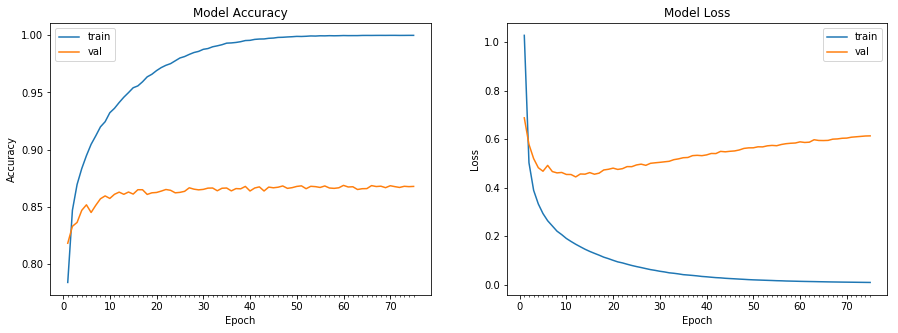

current variables:vgg16.0-SGD-0.01-25
current variables:vgg16.0-SGD-0.01-25


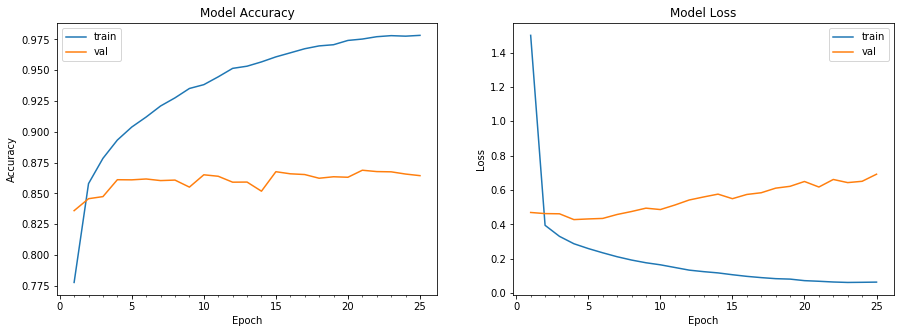

current variables:vgg16.0-SGD-0.01-50
current variables:vgg16.0-SGD-0.01-50


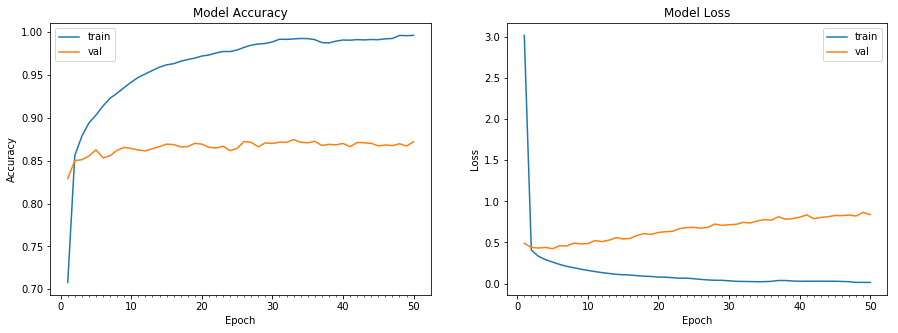

current variables:vgg16.0-SGD-0.01-75
current variables:vgg16.0-SGD-0.01-75


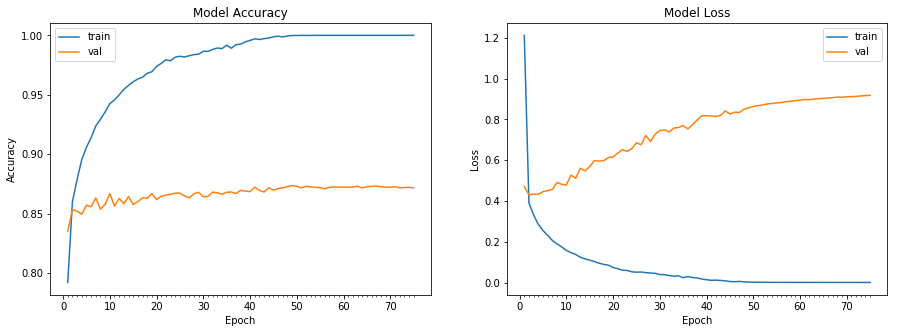

current variables:vgg16.0-SGD-0.1-25
current variables:vgg16.0-SGD-0.1-25


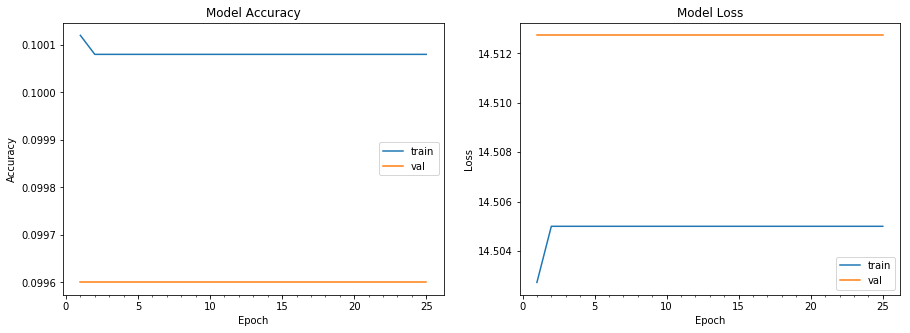

current variables:vgg16.0-SGD-0.1-50
current variables:vgg16.0-SGD-0.1-50


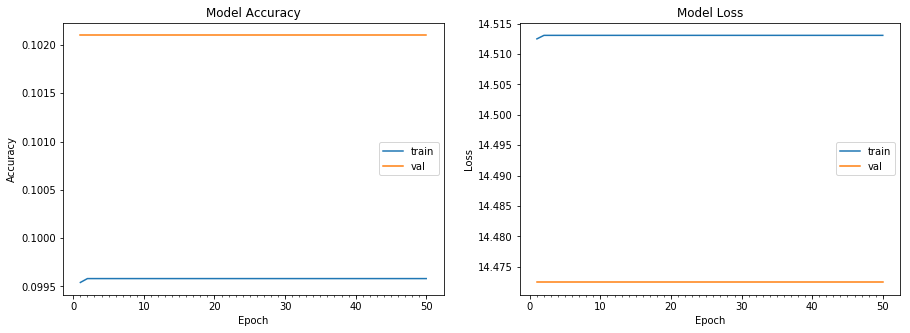

current variables:vgg16.0-SGD-0.1-75
current variables:vgg16.0-SGD-0.1-75


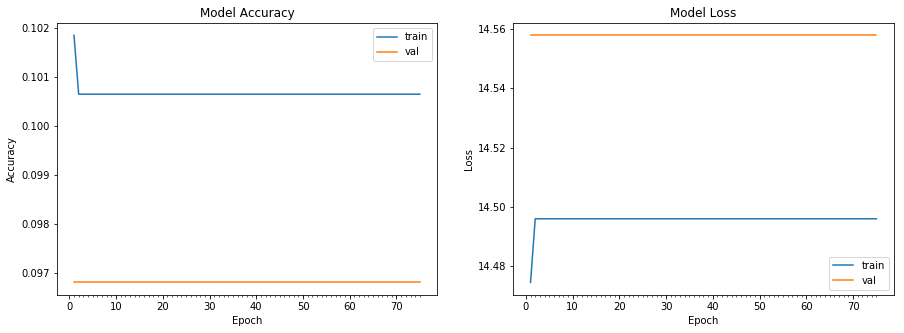

current variables:vgg16.0-SGD-0.3-25
current variables:vgg16.0-SGD-0.3-25


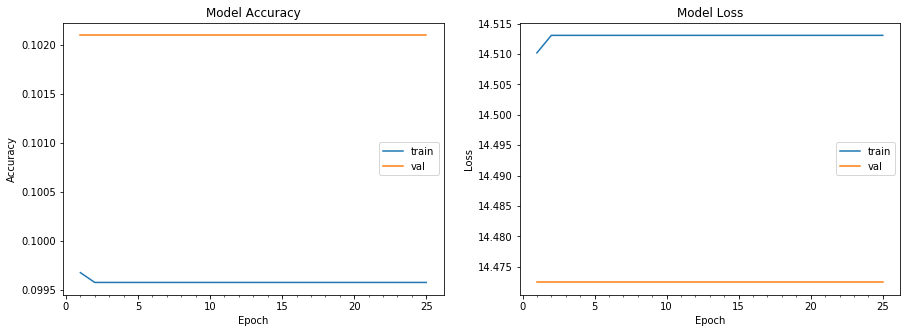

current variables:vgg16.0-SGD-0.3-50
current variables:vgg16.0-SGD-0.3-50


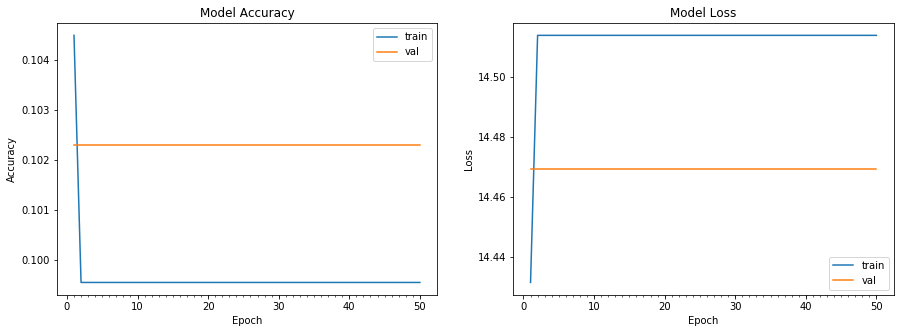

current variables:vgg16.0-SGD-0.3-75
current variables:vgg16.0-SGD-0.3-75


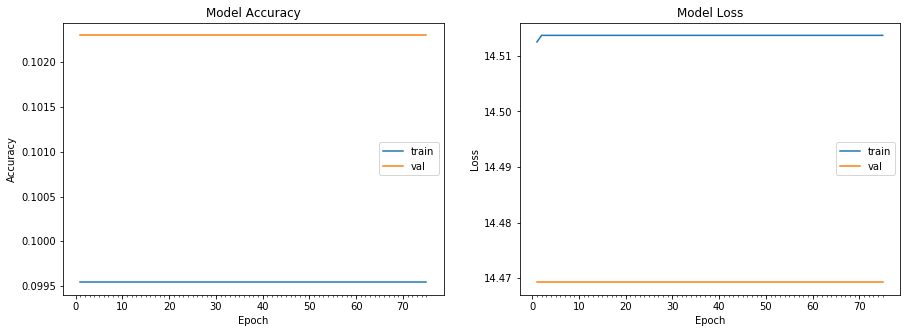

current variables:vgg16.1-Adam-0.001-25
current variables:vgg16.1-Adam-0.001-25


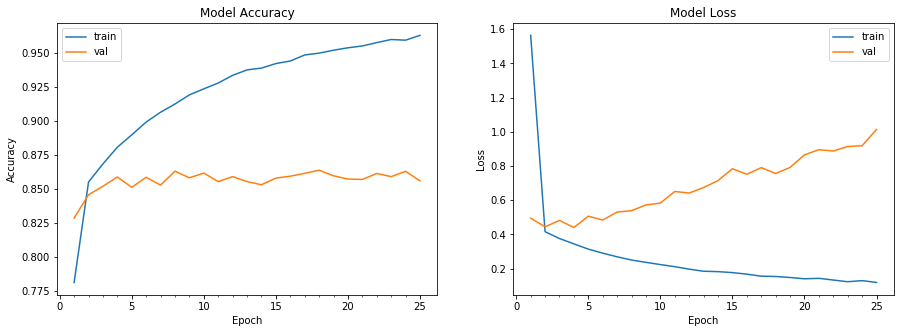

current variables:vgg16.1-Adam-0.001-50
current variables:vgg16.1-Adam-0.001-50


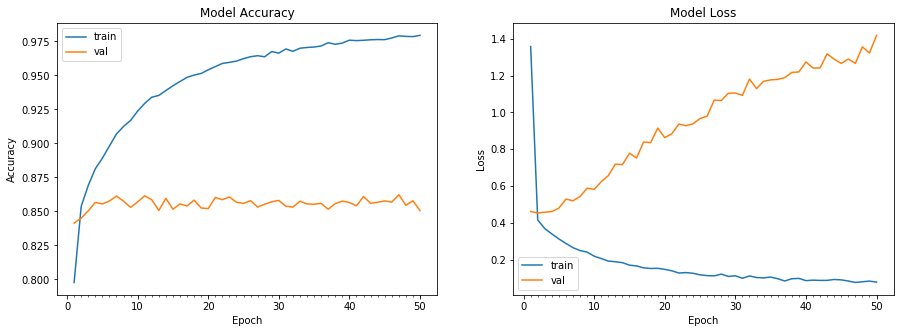

current variables:vgg16.1-Adam-0.001-75
current variables:vgg16.1-Adam-0.001-75


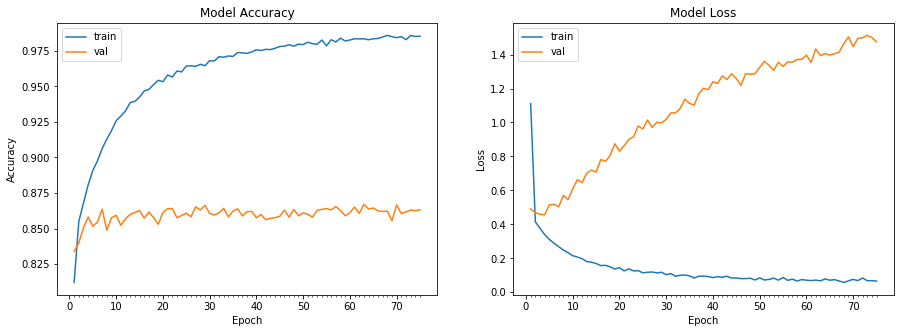

current variables:vgg16.1-Adam-0.01-25
current variables:vgg16.1-Adam-0.01-25


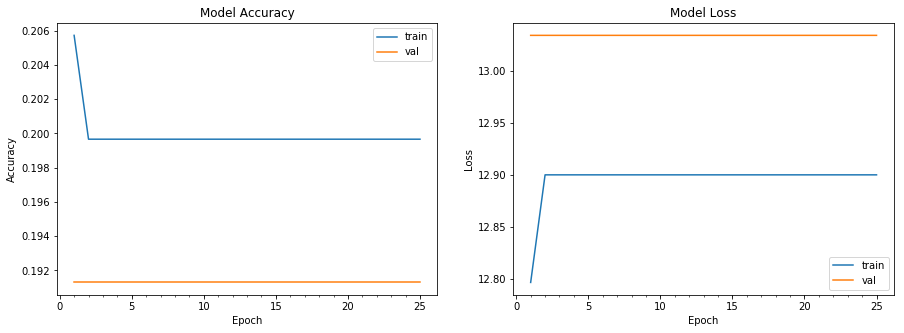

current variables:vgg16.1-Adam-0.01-50
current variables:vgg16.1-Adam-0.01-50


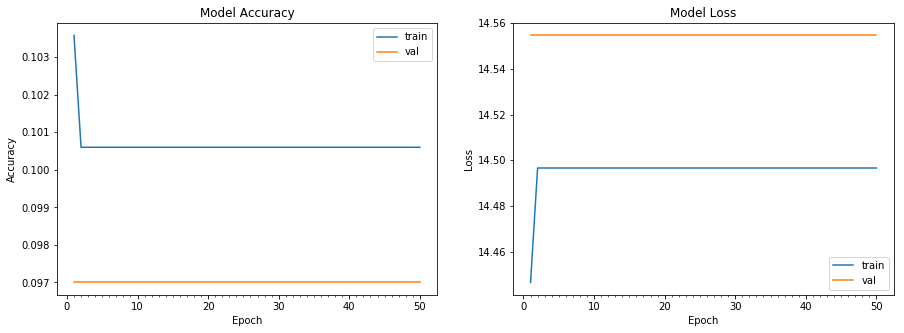

current variables:vgg16.1-Adam-0.01-75
current variables:vgg16.1-Adam-0.01-75


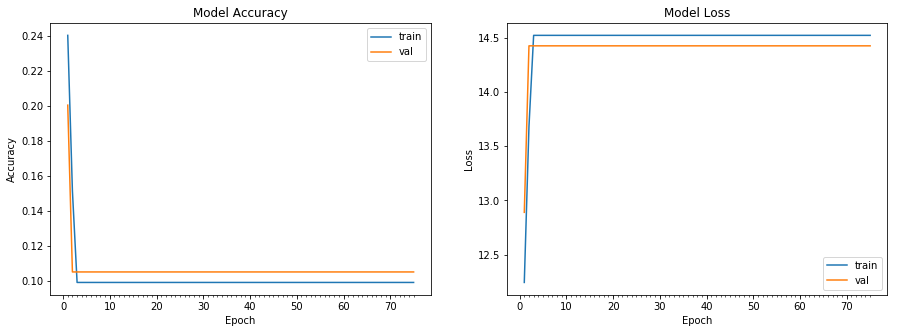

current variables:vgg16.1-Adam-0.1-25
current variables:vgg16.1-Adam-0.1-25


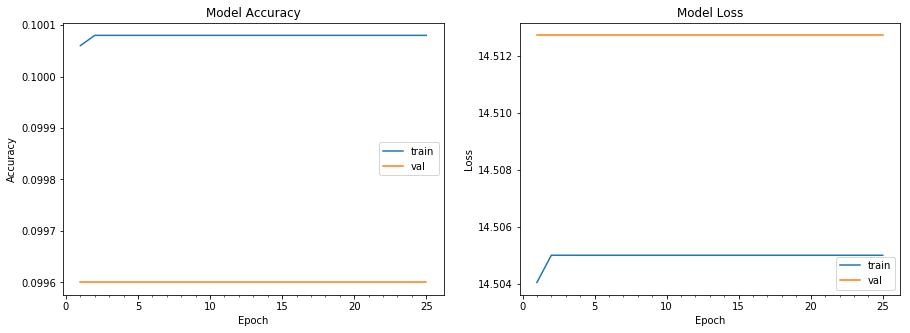

current variables:vgg16.1-Adam-0.1-50
current variables:vgg16.1-Adam-0.1-50


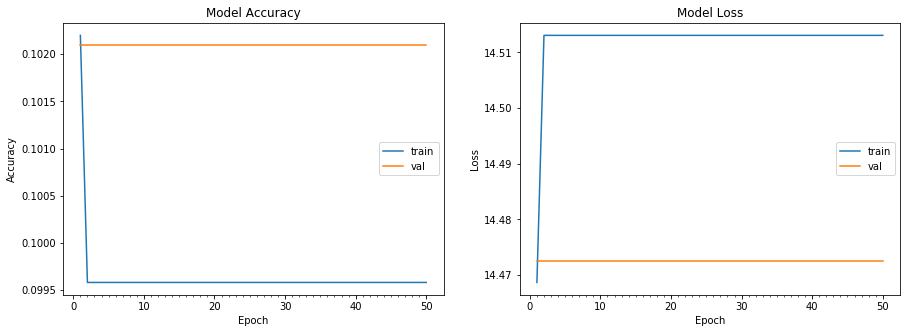

current variables:vgg16.1-Adam-0.1-75
current variables:vgg16.1-Adam-0.1-75


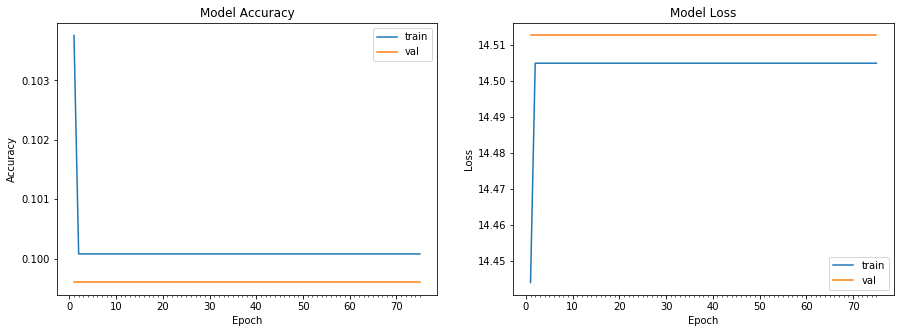

current variables:vgg16.1-Adam-0.3-25
current variables:vgg16.1-Adam-0.3-25


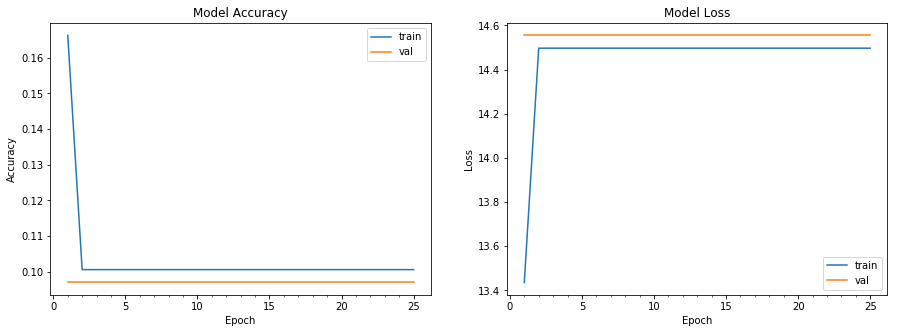

current variables:vgg16.1-Adam-0.3-50
current variables:vgg16.1-Adam-0.3-50


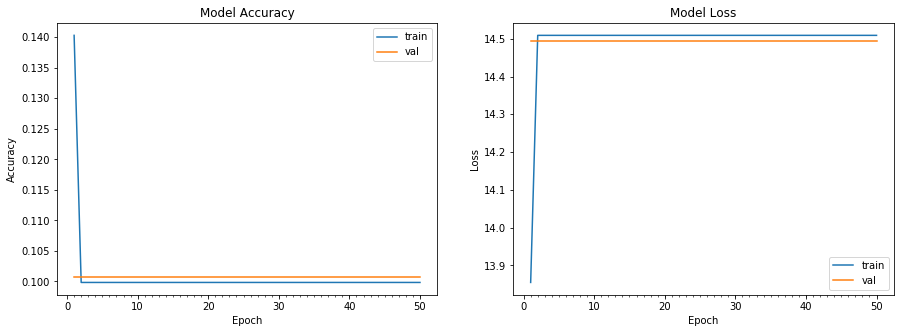

current variables:vgg16.1-Adam-0.3-75
current variables:vgg16.1-Adam-0.3-75


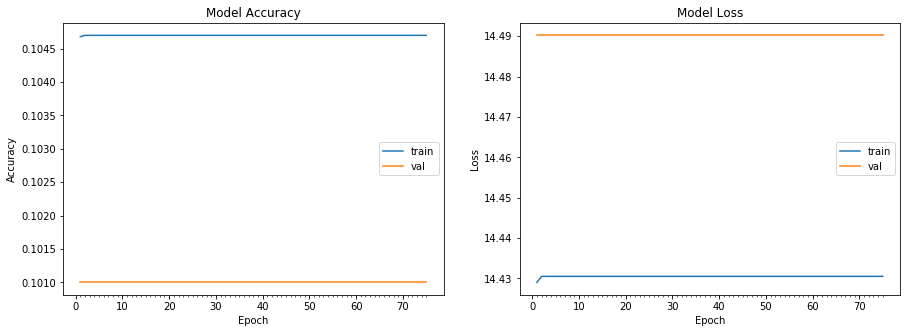

current variables:vgg16.1-SGD-0.001-25
current variables:vgg16.1-SGD-0.001-25


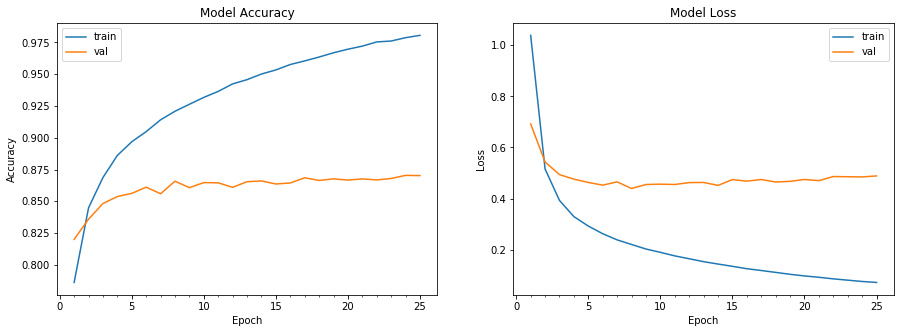

current variables:vgg16.1-SGD-0.001-50
current variables:vgg16.1-SGD-0.001-50


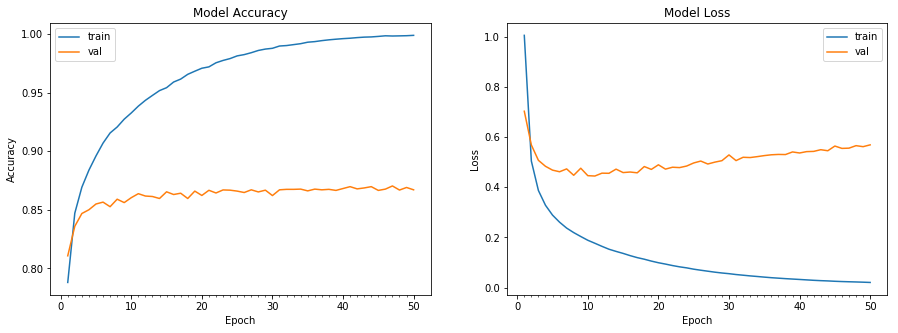

current variables:vgg16.1-SGD-0.001-75
current variables:vgg16.1-SGD-0.001-75


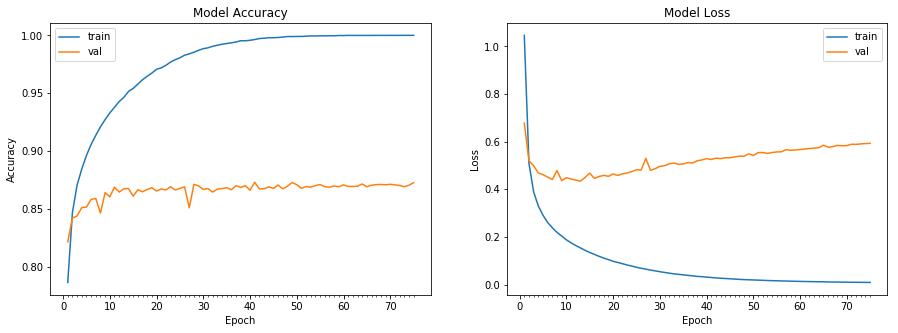

current variables:vgg16.1-SGD-0.01-25
current variables:vgg16.1-SGD-0.01-25


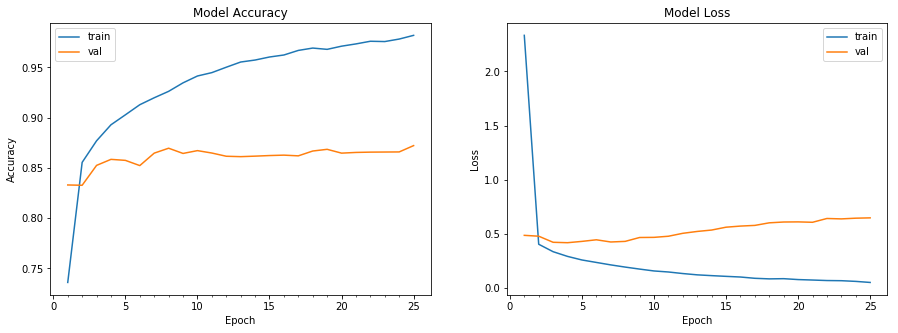

current variables:vgg16.1-SGD-0.01-50
current variables:vgg16.1-SGD-0.01-50


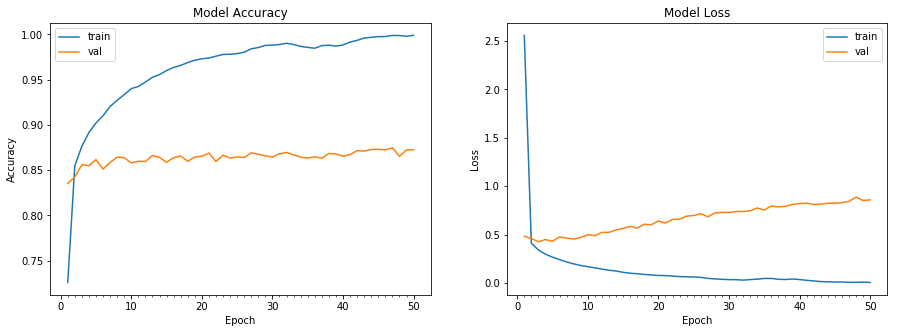

current variables:vgg16.1-SGD-0.01-75
current variables:vgg16.1-SGD-0.01-75


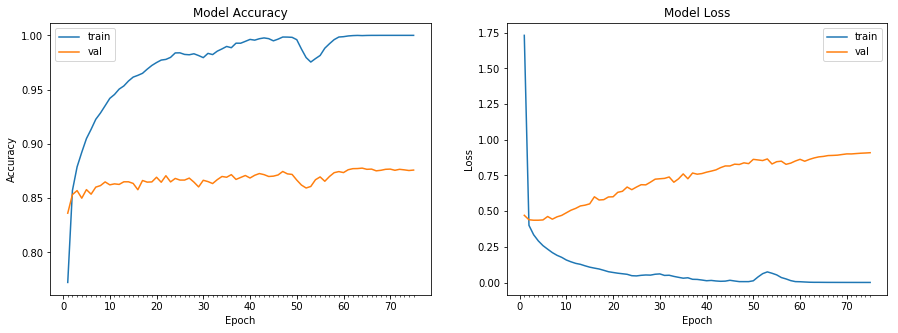

current variables:vgg16.1-SGD-0.1-25
current variables:vgg16.1-SGD-0.1-25


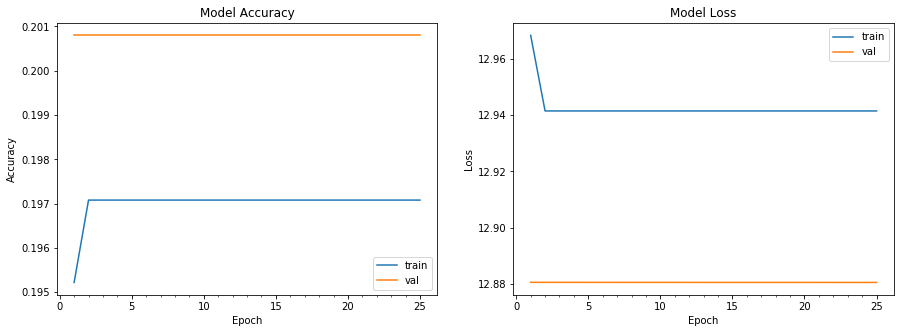

current variables:vgg16.1-SGD-0.1-50
current variables:vgg16.1-SGD-0.1-50


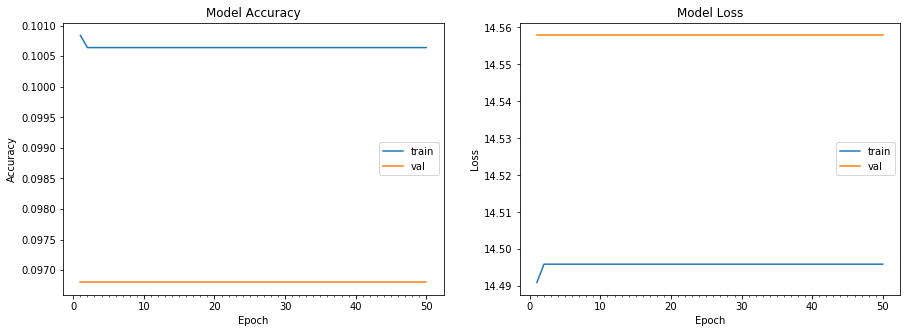

current variables:vgg16.1-SGD-0.1-75
current variables:vgg16.1-SGD-0.1-75


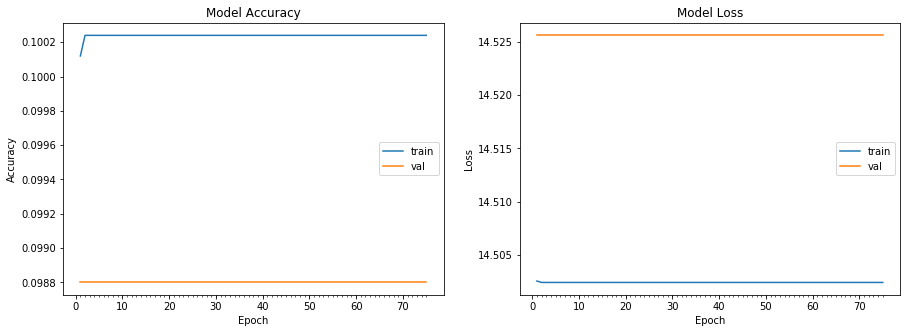

current variables:vgg16.1-SGD-0.3-25
current variables:vgg16.1-SGD-0.3-25


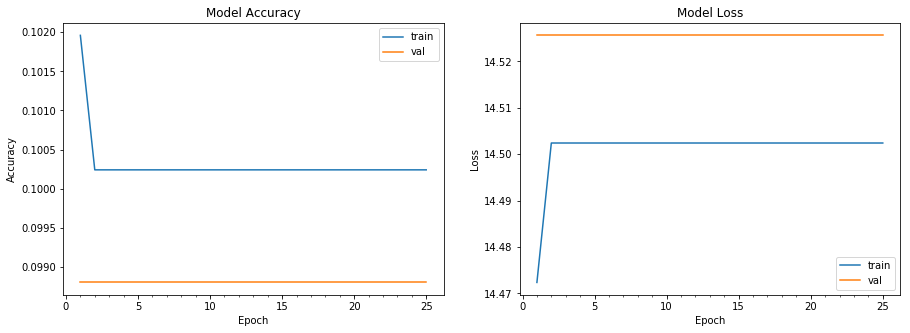

current variables:vgg16.1-SGD-0.3-50
current variables:vgg16.1-SGD-0.3-50


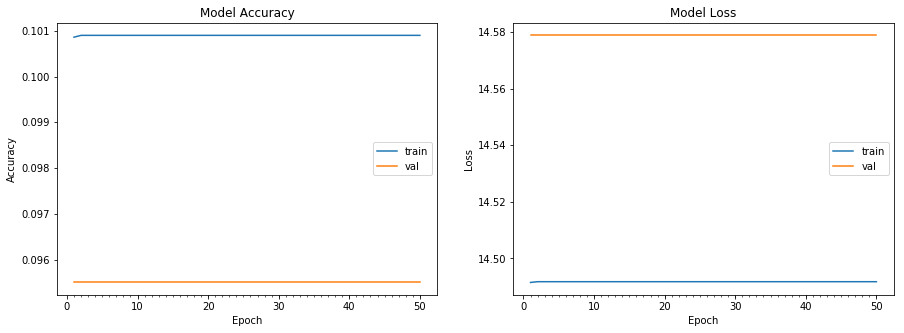

current variables:vgg16.1-SGD-0.3-75
current variables:vgg16.1-SGD-0.3-75


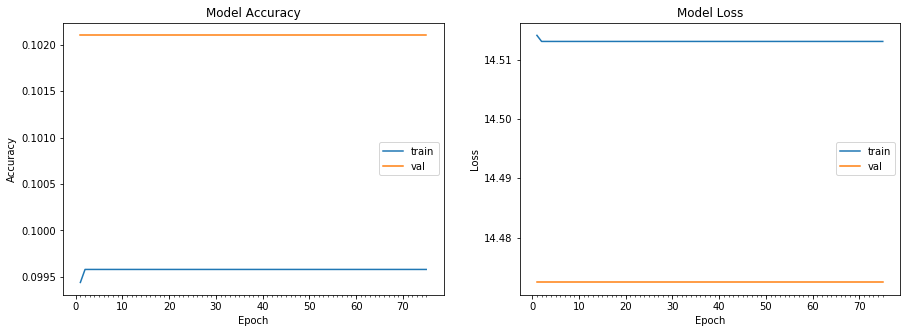

current variables:vgg16.2-Adam-0.001-25
current variables:vgg16.2-Adam-0.001-25


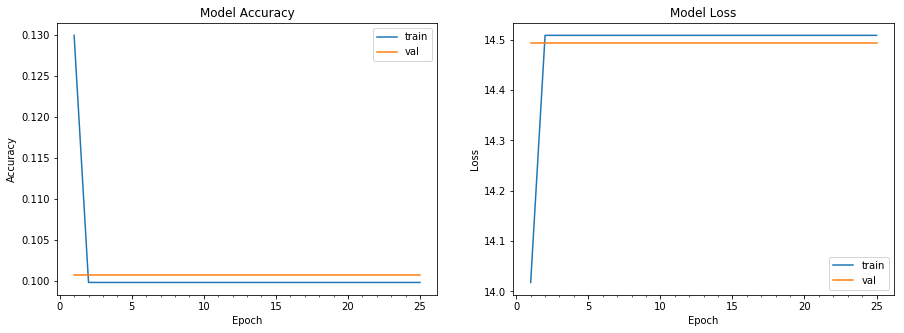

current variables:vgg16.2-Adam-0.001-50
current variables:vgg16.2-Adam-0.001-50


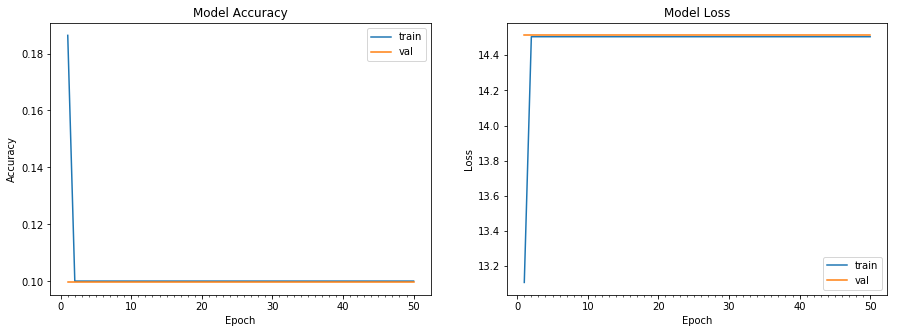

current variables:vgg16.2-Adam-0.001-75
current variables:vgg16.2-Adam-0.001-75


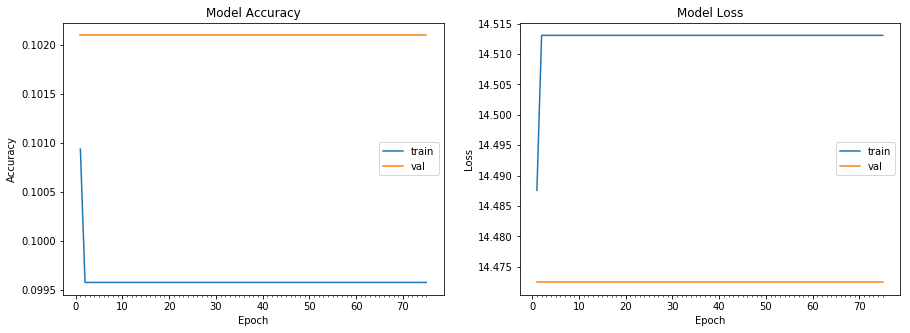

current variables:vgg16.2-Adam-0.01-25
current variables:vgg16.2-Adam-0.01-25


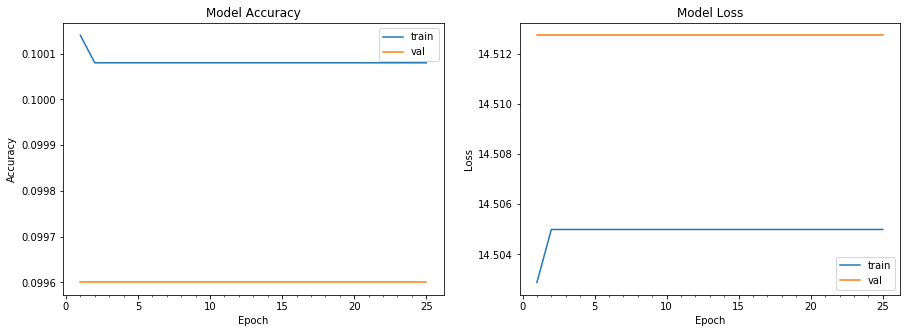

current variables:vgg16.2-Adam-0.01-50
current variables:vgg16.2-Adam-0.01-50


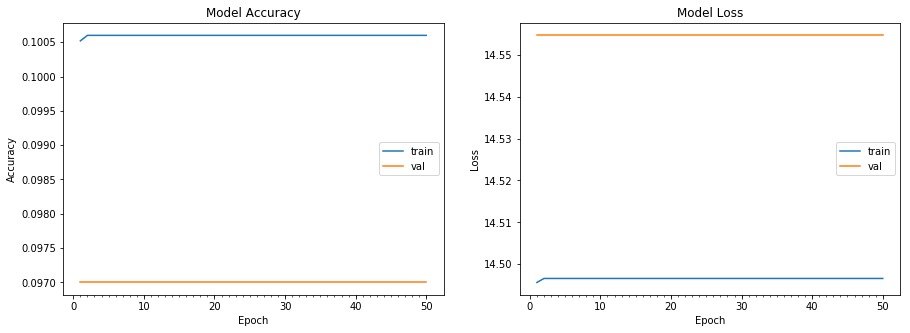

current variables:vgg16.2-Adam-0.01-75
current variables:vgg16.2-Adam-0.01-75


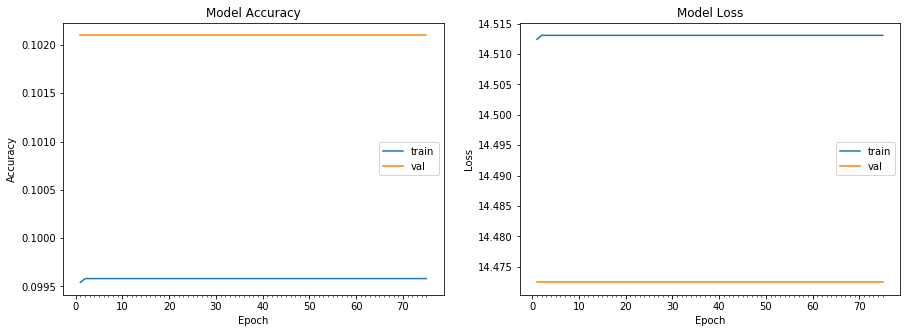

current variables:vgg16.2-Adam-0.1-25
current variables:vgg16.2-Adam-0.1-25


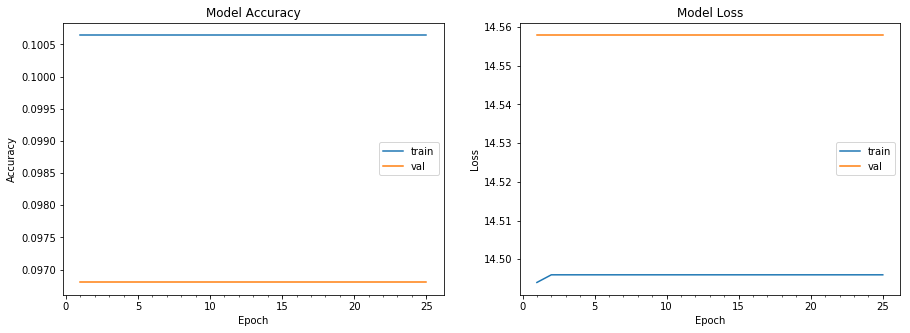

current variables:vgg16.2-Adam-0.1-50
current variables:vgg16.2-Adam-0.1-50


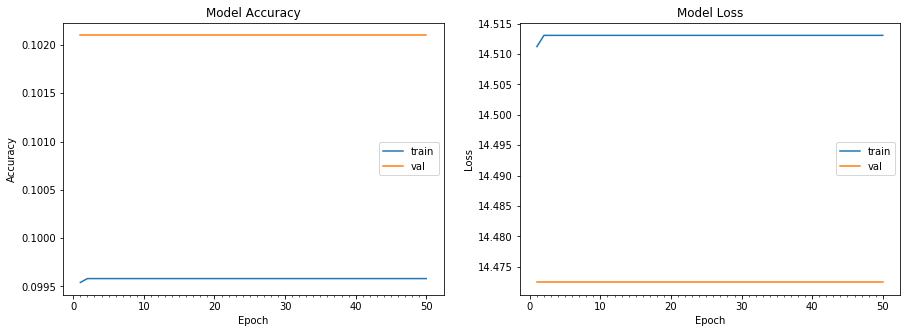

current variables:vgg16.2-Adam-0.1-75
current variables:vgg16.2-Adam-0.1-75


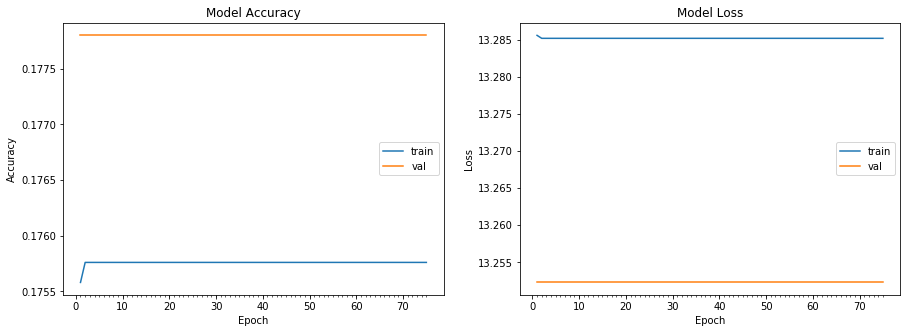

current variables:vgg16.2-Adam-0.3-25
current variables:vgg16.2-Adam-0.3-25


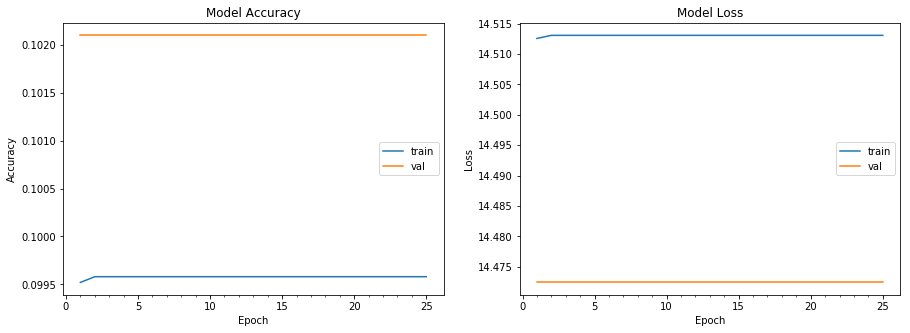

current variables:vgg16.2-Adam-0.3-50
current variables:vgg16.2-Adam-0.3-50


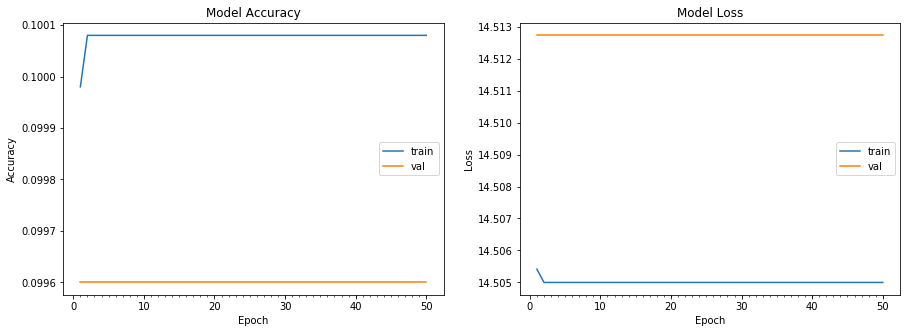

current variables:vgg16.2-Adam-0.3-75
current variables:vgg16.2-Adam-0.3-75


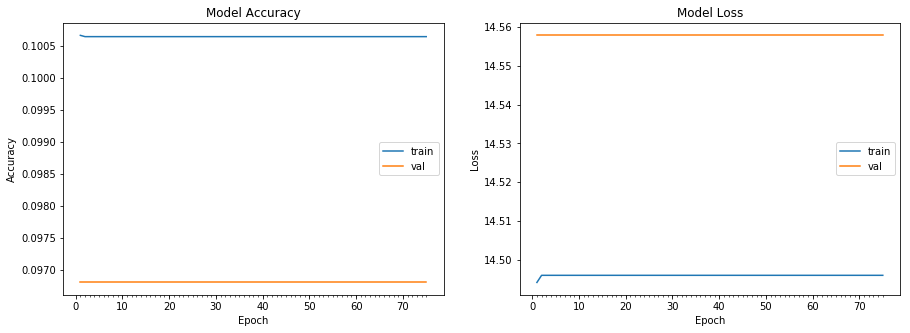

current variables:vgg16.2-SGD-0.001-25
current variables:vgg16.2-SGD-0.001-25


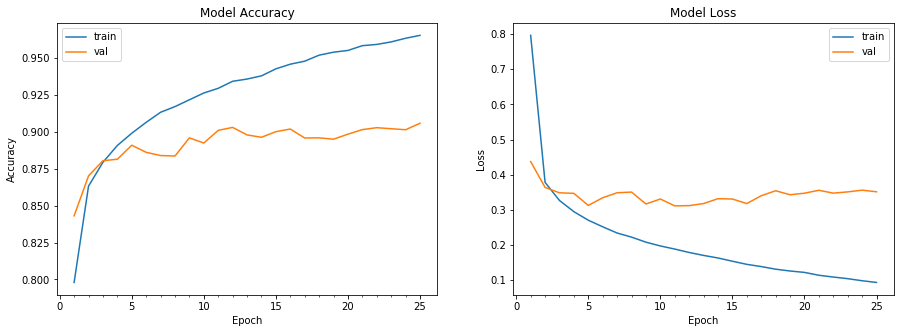

current variables:vgg16.2-SGD-0.001-50
current variables:vgg16.2-SGD-0.001-50


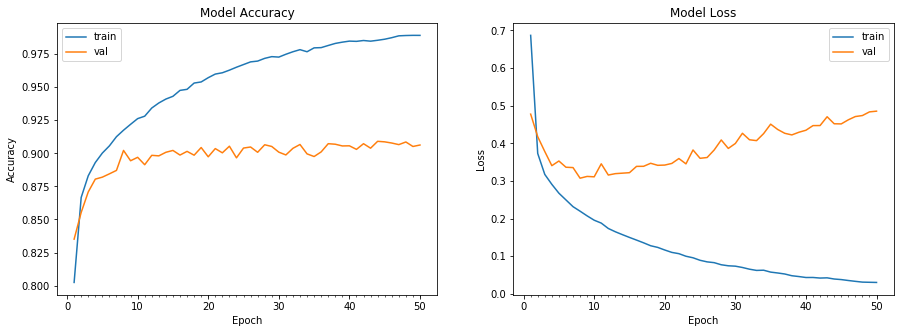

current variables:vgg16.2-SGD-0.001-75
current variables:vgg16.2-SGD-0.001-75


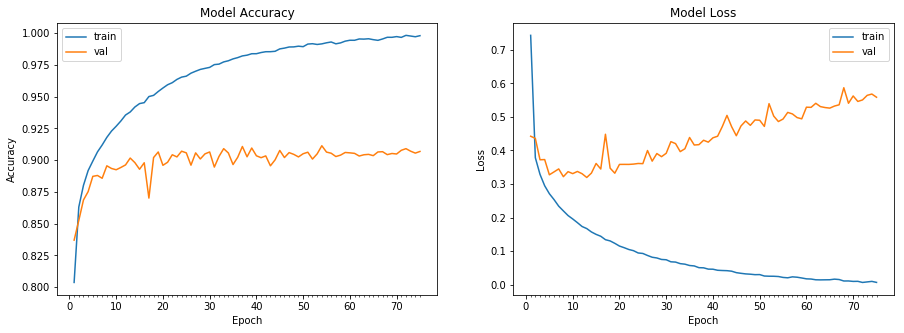

current variables:vgg16.2-SGD-0.01-25
current variables:vgg16.2-SGD-0.01-25


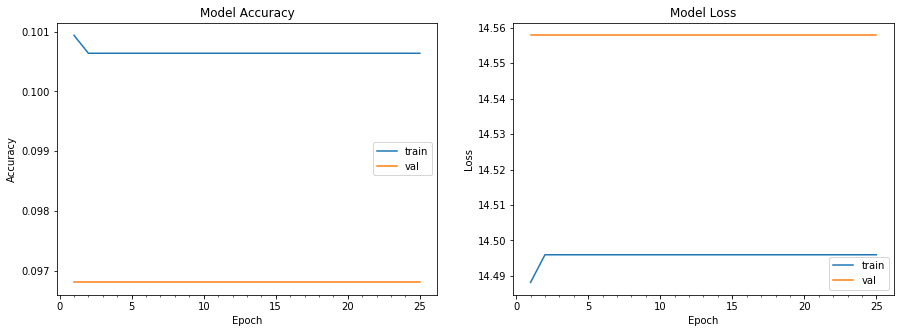

current variables:vgg16.2-SGD-0.01-50
current variables:vgg16.2-SGD-0.01-50


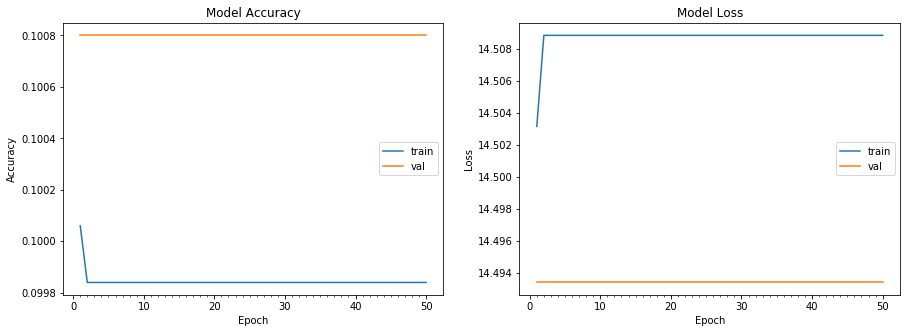

current variables:vgg16.2-SGD-0.01-75
current variables:vgg16.2-SGD-0.01-75


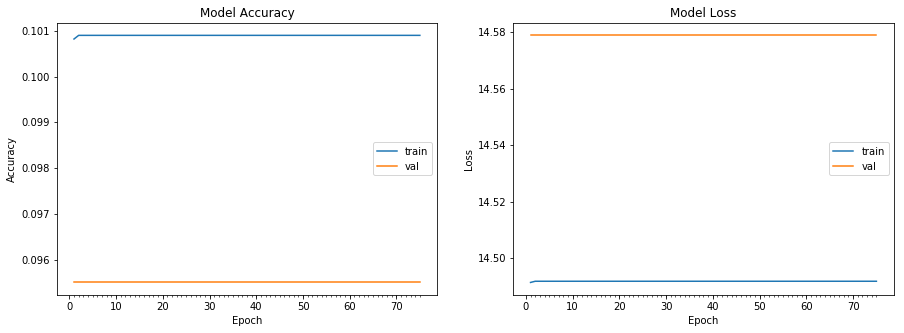

current variables:vgg16.2-SGD-0.1-25
current variables:vgg16.2-SGD-0.1-25


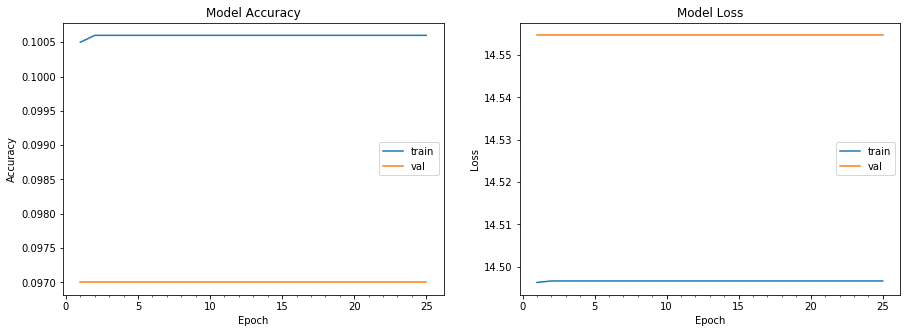

current variables:vgg16.2-SGD-0.1-50
current variables:vgg16.2-SGD-0.1-50


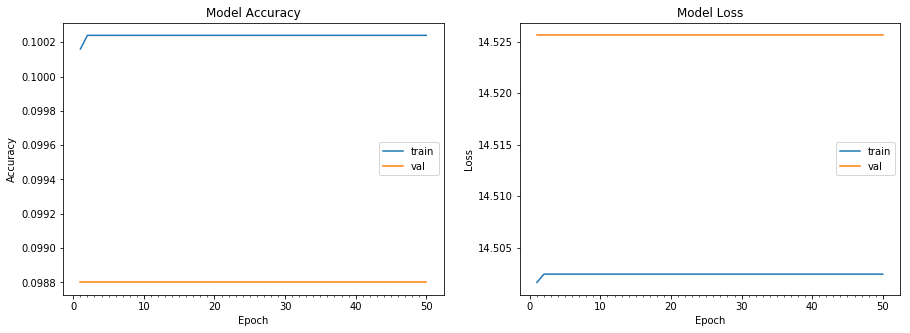

current variables:vgg16.2-SGD-0.1-75
current variables:vgg16.2-SGD-0.1-75


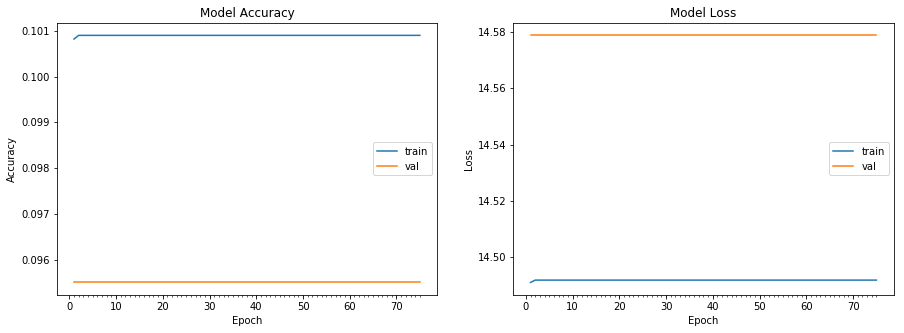

current variables:vgg16.2-SGD-0.3-25
current variables:vgg16.2-SGD-0.3-25


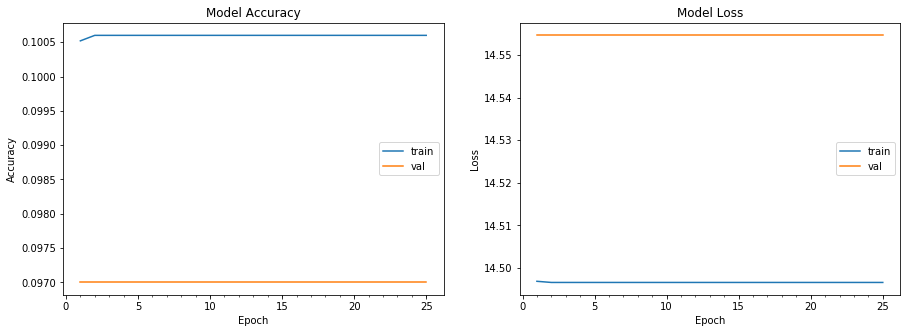

current variables:vgg16.2-SGD-0.3-50
current variables:vgg16.2-SGD-0.3-50


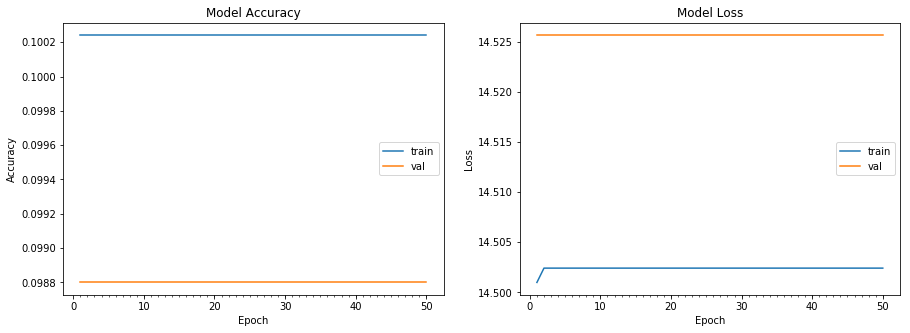

current variables:vgg16.2-SGD-0.3-75
current variables:vgg16.2-SGD-0.3-75


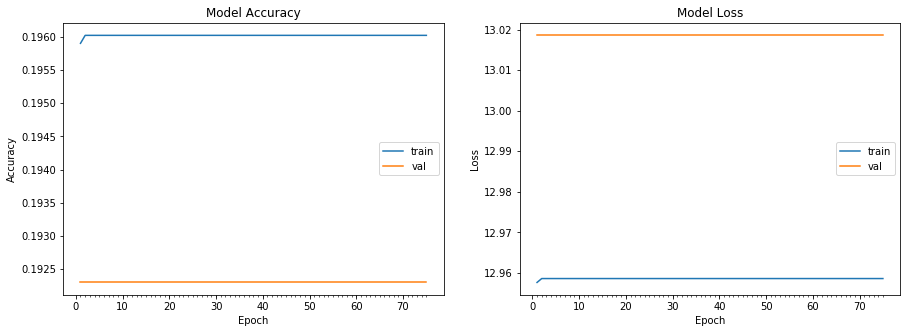

current variables:vgg16.3-Adam-0.001-25
current variables:vgg16.3-Adam-0.001-25


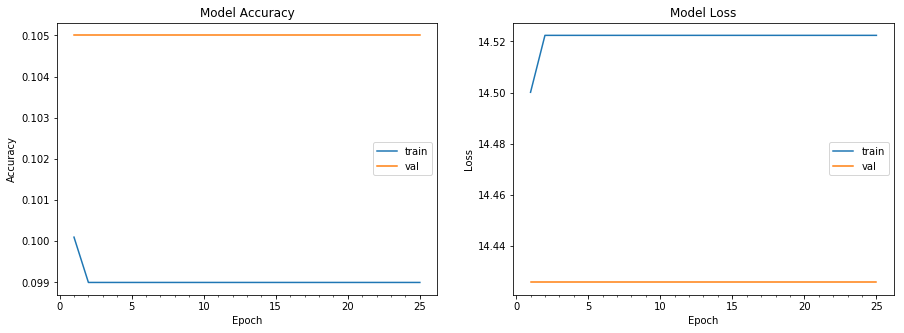

current variables:vgg16.3-Adam-0.001-50
current variables:vgg16.3-Adam-0.001-50


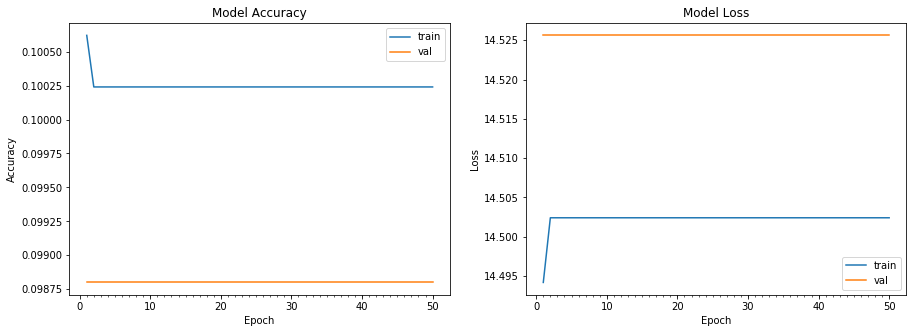

current variables:vgg16.3-Adam-0.001-75
current variables:vgg16.3-Adam-0.001-75


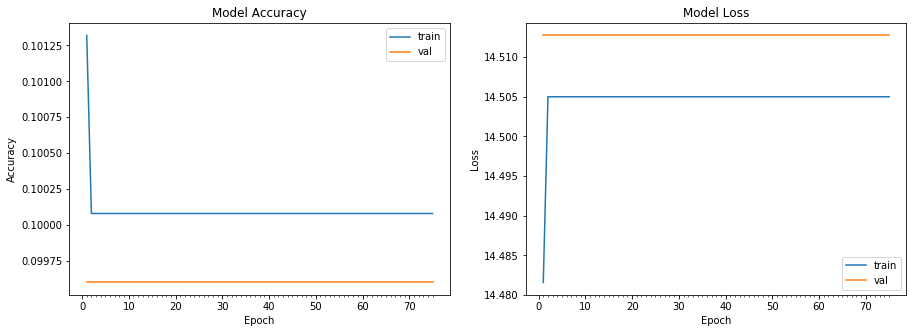

current variables:vgg16.3-Adam-0.01-25
current variables:vgg16.3-Adam-0.01-25


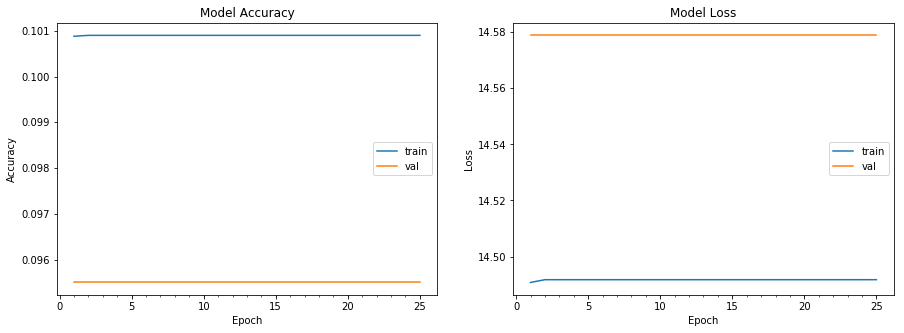

current variables:vgg16.3-Adam-0.01-50
current variables:vgg16.3-Adam-0.01-50


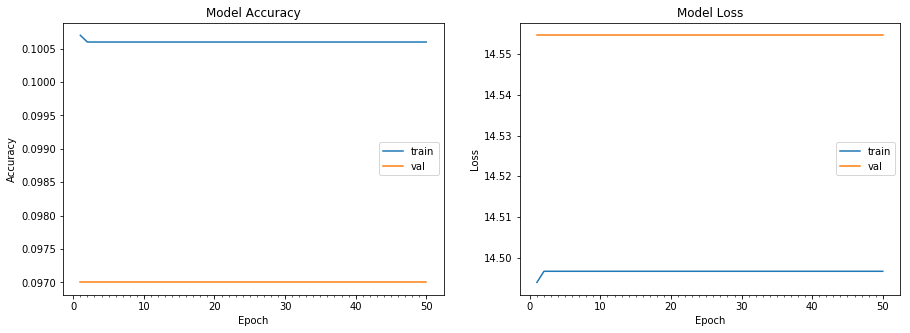

current variables:vgg16.3-Adam-0.01-75


KeyboardInterrupt: 

In [23]:
tune_model(train_vgg_batches, test_vgg_batches, 'vgg16', range_num_of_train_layer = 3, optimizer_list = ['Adam', 'SGD'], learning_rate_list = [0.001, 0.01, 0.1, 0.3], epoch_list = [25, 50, 75])

current variables:self.0-Adam-0.001-25
current variables:self.0-Adam-0.001-25


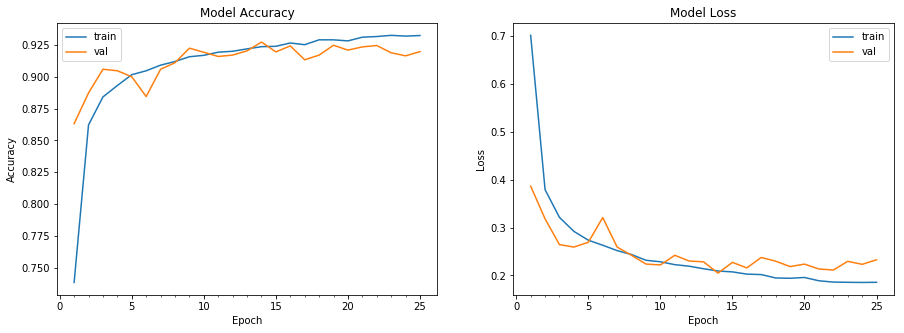

current variables:self.0-Adam-0.001-50
current variables:self.0-Adam-0.001-50


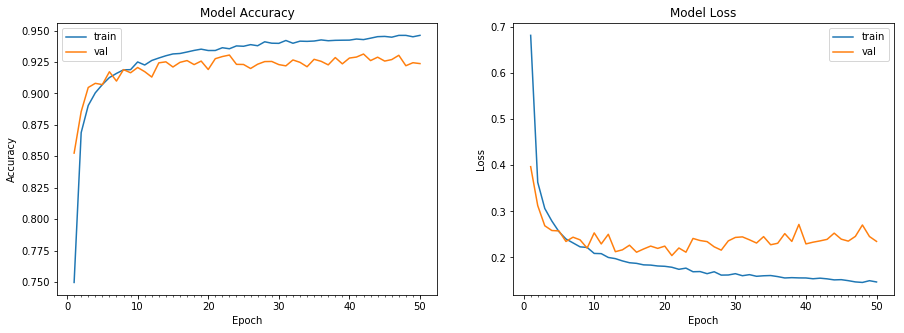

current variables:self.0-Adam-0.001-75
current variables:self.0-Adam-0.001-75


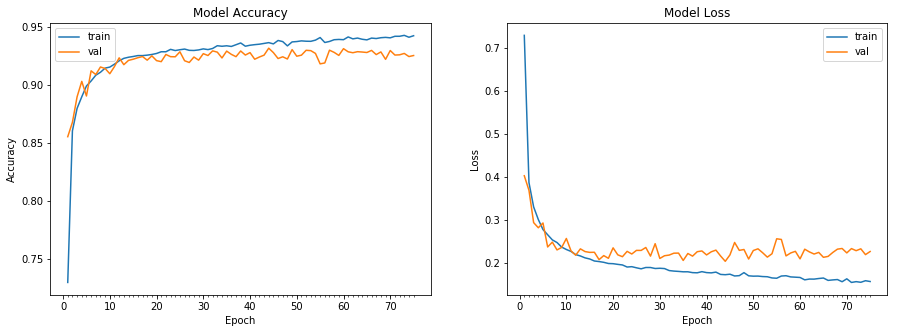

current variables:self.0-Adam-0.01-25
current variables:self.0-Adam-0.01-25


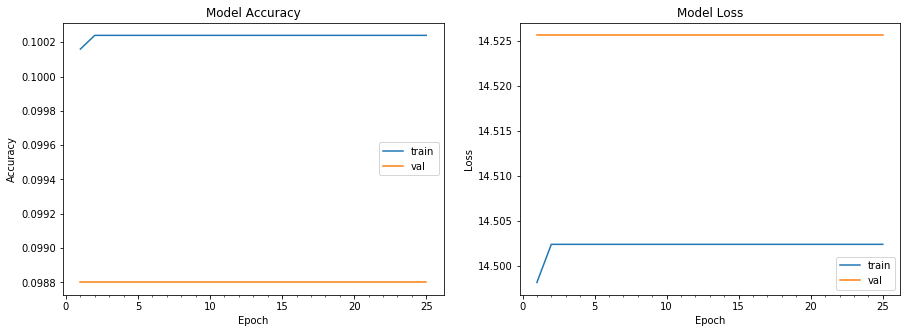

current variables:self.0-Adam-0.01-50
current variables:self.0-Adam-0.01-50


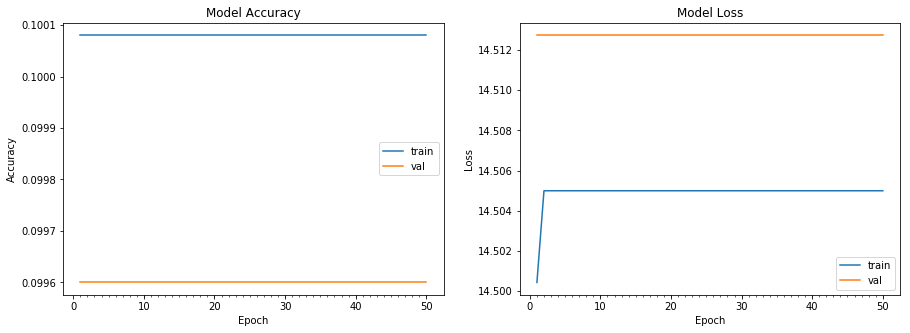

current variables:self.0-Adam-0.01-75
current variables:self.0-Adam-0.01-75


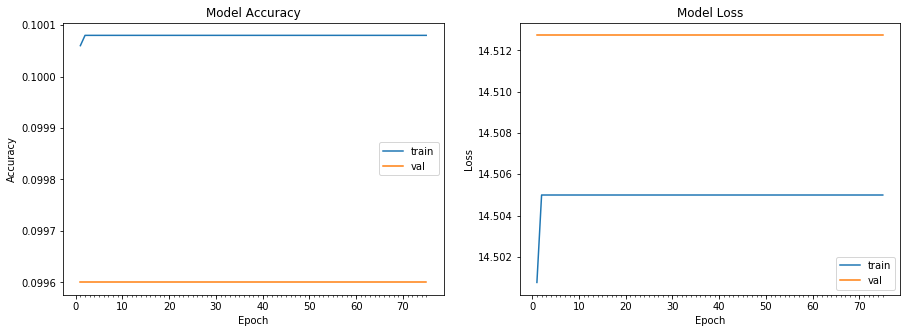

current variables:self.0-Adam-0.1-25
current variables:self.0-Adam-0.1-25


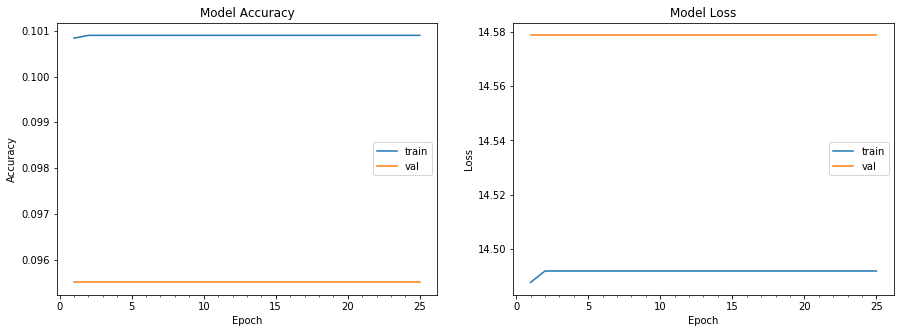

current variables:self.0-Adam-0.1-50
current variables:self.0-Adam-0.1-50


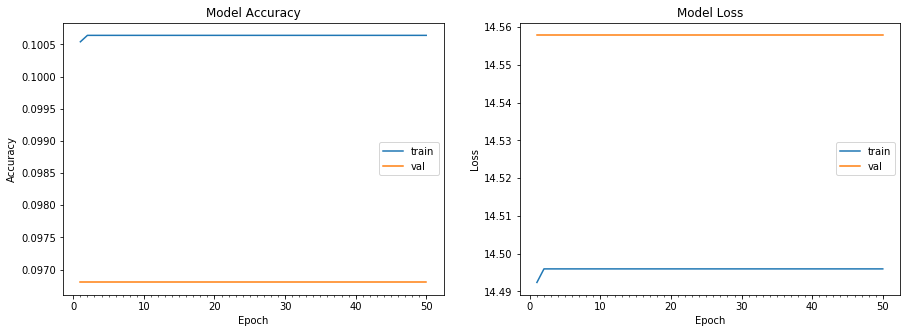

current variables:self.0-Adam-0.1-75
current variables:self.0-Adam-0.1-75


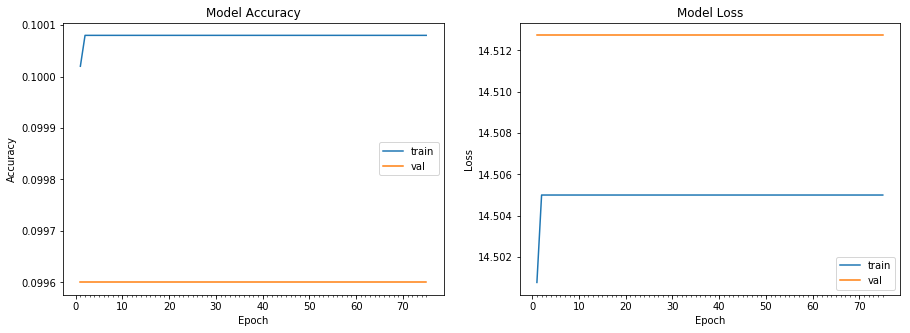

current variables:self.0-Adam-0.3-25
current variables:self.0-Adam-0.3-25


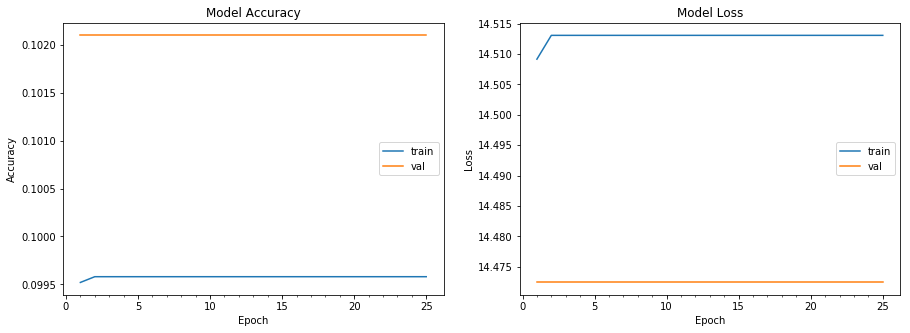

current variables:self.0-Adam-0.3-50
current variables:self.0-Adam-0.3-50


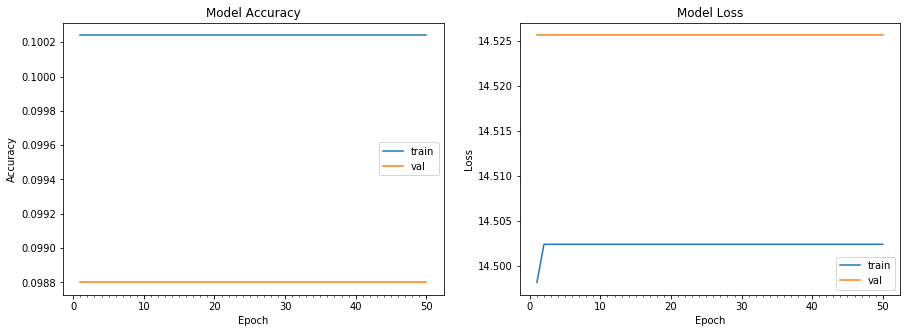

current variables:self.0-Adam-0.3-75
current variables:self.0-Adam-0.3-75


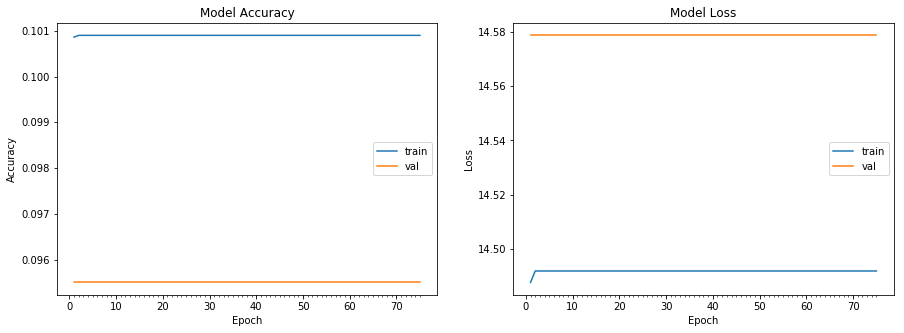

current variables:self.0-SGD-0.001-25
current variables:self.0-SGD-0.001-25


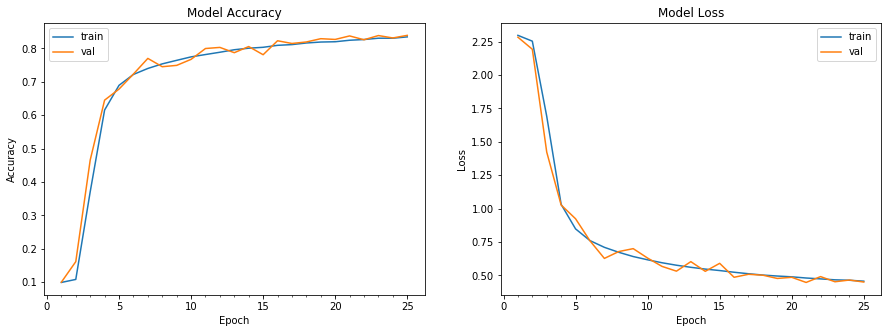

current variables:self.0-SGD-0.001-50
current variables:self.0-SGD-0.001-50


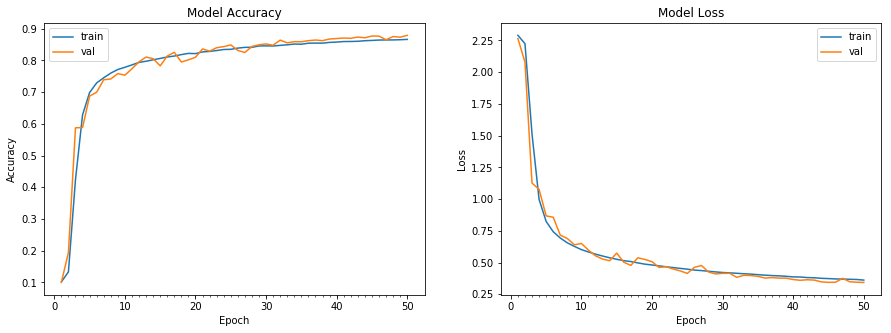

current variables:self.0-SGD-0.001-75
current variables:self.0-SGD-0.001-75


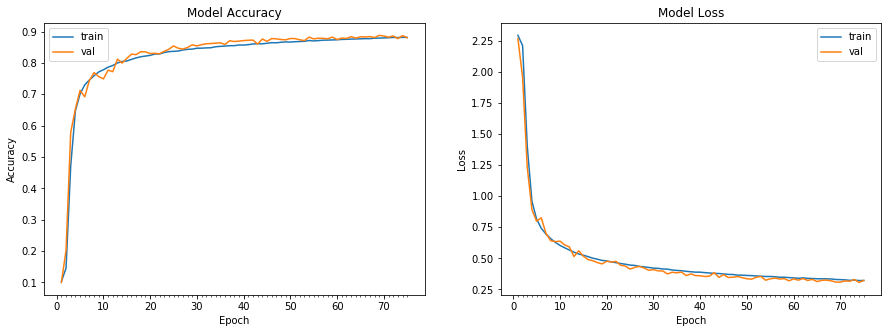

current variables:self.0-SGD-0.01-25
current variables:self.0-SGD-0.01-25


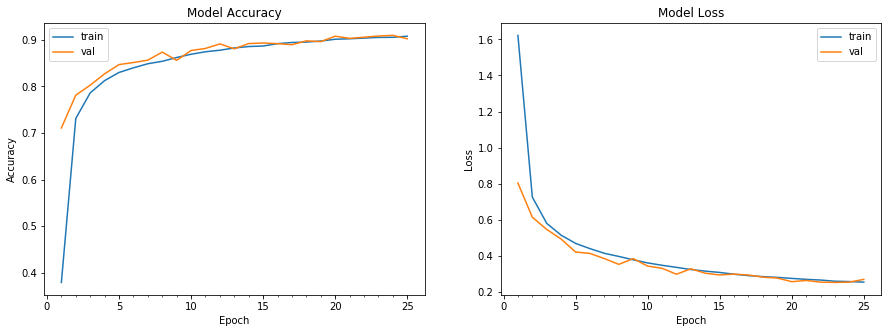

current variables:self.0-SGD-0.01-50
current variables:self.0-SGD-0.01-50


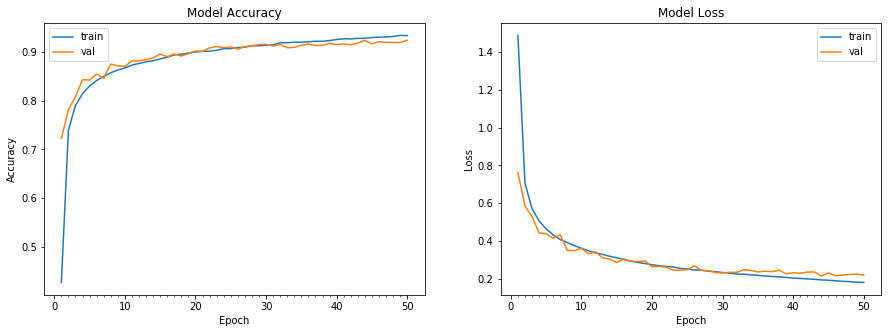

current variables:self.0-SGD-0.01-75
current variables:self.0-SGD-0.01-75


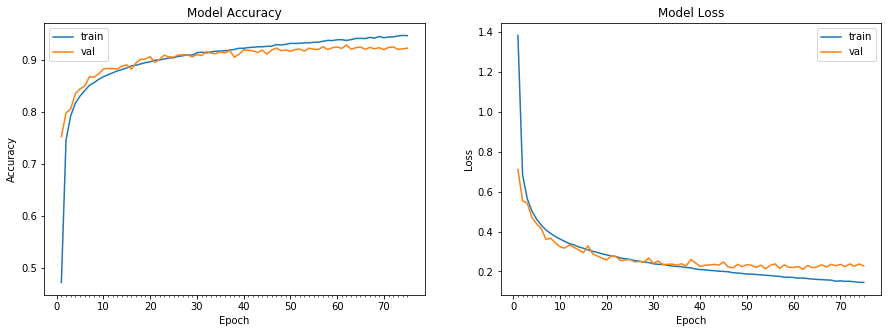

current variables:self.0-SGD-0.1-25
current variables:self.0-SGD-0.1-25


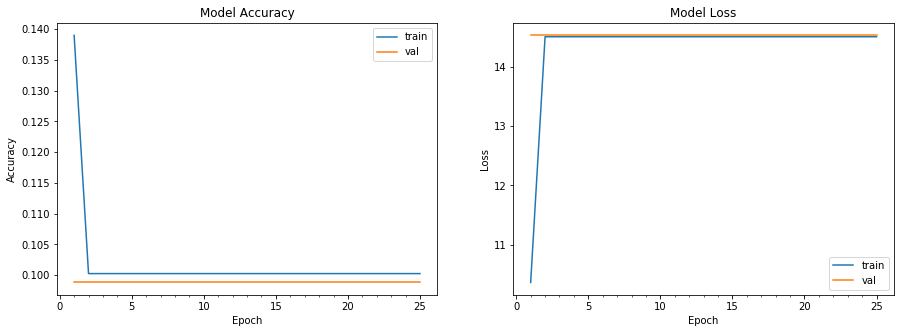

current variables:self.0-SGD-0.1-50
current variables:self.0-SGD-0.1-50


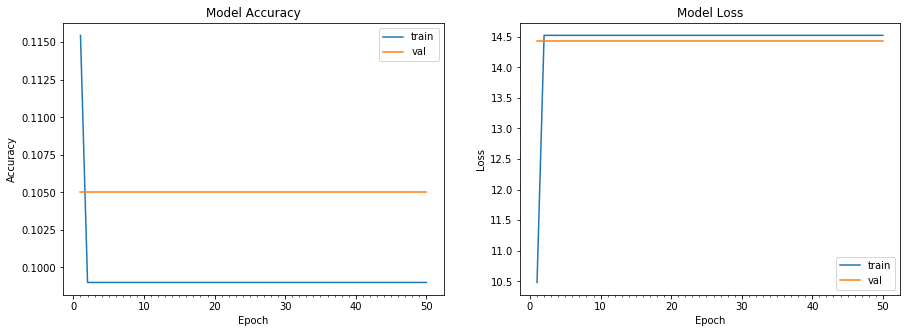

current variables:self.0-SGD-0.1-75
current variables:self.0-SGD-0.1-75


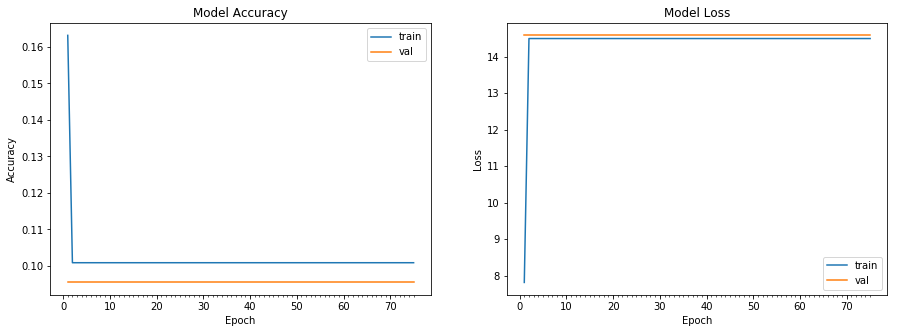

current variables:self.0-SGD-0.3-25
current variables:self.0-SGD-0.3-25


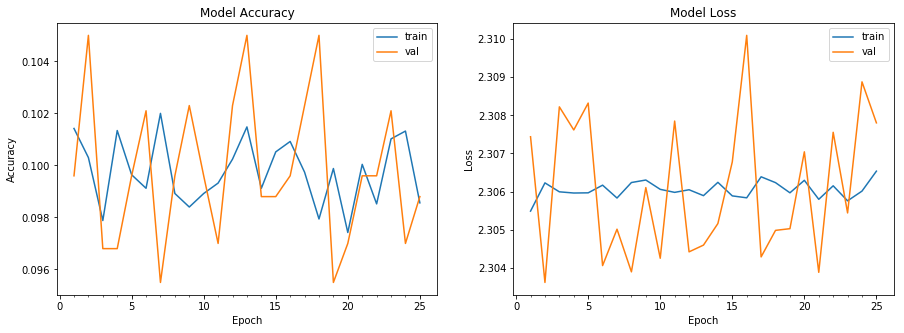

current variables:self.0-SGD-0.3-50
current variables:self.0-SGD-0.3-50


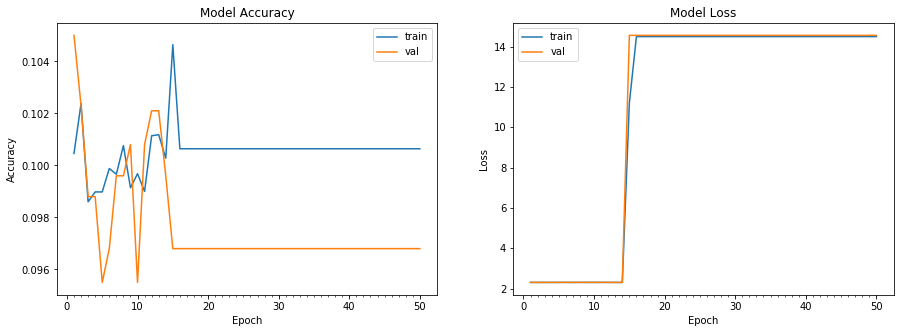

current variables:self.0-SGD-0.3-75
current variables:self.0-SGD-0.3-75


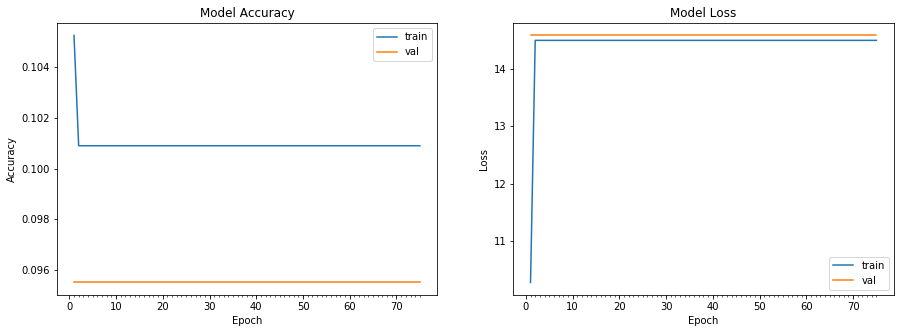

In [24]:
tune_model(train_self_batches, test_self_batches, 'self', range_num_of_train_layer = 1, optimizer_list = ['Adam', 'SGD'], learning_rate_list = [0.001, 0.01, 0.1, 0.3], epoch_list = [25, 50, 75])

# get best models

In [25]:
def get_best_models(model_folder_path):
  
  fileNames = os.listdir( model_folder_path )
  best_model_path = {}
  model_info = {}
  
  for i in range(0, len(fileNames)):
    if '.h5' in fileNames[i]:
      model_type = fileNames[i].split('.')[0] + '.' + fileNames[i].split('.')[1][0]
      suf = fileNames[i].split('-')[-1]
      loss = float(suf[0:len(suf)-3])
      if model_type in model_info:
        if loss < model_info[model_type]:
          model_info[model_type] = loss
          best_model_path[model_type] = fileNames[i]
      else:
        model_info[model_type] = loss
        best_model_path[model_type] = fileNames[i]
  
  models = []
  for k, v in best_model_path.items():
    models.append(load_model(model_folder_path + '/' + v))
    
  return models

In [28]:
best_models = get_best_models('/media/ryantsan/UBUNTU 18_0/models')

# ensemble

In [ ]:
def weight_voting_pred(best_models):
  
  pred_prob = []
  acc = []
  for i in range(0,len(best_models)):
    pred_prob.append(best_models[i].predict_generator(test_batches,steps=test_step, verbose=1))
    acc.append(accuracy_score(y_test, get_labels(pred_prob[i])))

  print('original accuracy:')
  print(acc)
  acc = np.array(acc)
  pred_prob = np.array(pred_prob)
  acc_sum = np.sum(acc, axis = 0)
  model_weights = acc / acc_sum
  
  ens_pred = np.dot(pred_prob.T, model_weights).T
  
  return ens_pred

In [ ]:
ens_pred_1 = weight_voting_pred(best_models)
print('ensemble accuracy:')
print(accuracy_score(y_test, get_labels(ens_pred)))